In [1]:
import sys
import os
import time
import warnings
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler
from matplotlib import ticker
from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp
from utils import get_defect_list, get_defect_arr_from_frame, get_frame_number, do_chi2_fit
from AnalyseDefects import AnalyseDefects

## Set plotting style and print options
plt.style.use('sg_article')
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 0, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

In [2]:
def get_pair_corr_function(ar, ar_path, ball_window, frame_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, frame_interval[0], Nframes, archive_path=ar_path)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def get_pair_corr_from_defect_list(defect_list, ball_window, frame_idx_interval = None, method = "fv", \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40), save=False, save_dir=None, save_suffix=None):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = len(defect_list) if frame_idx_interval is None else frame_idx_interval[1] - frame_idx_interval[0]
    frame_interval = [0, Nframes - 1] if frame_idx_interval is None else frame_idx_interval

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[frame])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    if save:
        if save_dir is not None:
            if not os.path.isdir(save_dir):
                os.makedirs(save_dir)
        np.save(save_dir + f'rad_arr{save_suffix}.npy', rad_arr)
        np.save(save_dir + f'pcf_arr{save_suffix}.npy', pcf_arr)

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, method = 'fv', \
                            kest_kwargs = {'rmax': 10, 'correction': 'best', 'var.approx': False},\
                                method_kwargs = dict(method="b", spar=0.2, nknots=40),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=kest_kwargs, fv=method_kwargs)


    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None, plot_norm = False):
    """
    Plot pair correlation function
    """
    if isinstance(pcf_estimated, pd.DataFrame):
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    if plot_norm:
        g = np.abs(g)

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, '-')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        sf = StructureFactor(point_pattern)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if i == 0:
            kbins_arr = kbins.astype('float')
            sf_arr = np.empty([Nframes, len(kbins_arr), 2])
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Initialize structure factor
    sf_arr = None

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method='fv', \
                                 Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr



In [3]:
LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_dir_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_dir_list, output_path=output_path)

In [7]:
N = 0
kbins, sfac, rad = ad.get_sfac_pcf(Ndataset = N, time_av=False, weighted=False)[:3]
sfac_tav = ad.get_sfac_pcf(Ndataset = N, time_av=True,)[1]
output_path = ad.output_paths[N]
fitp = np.load(f'{output_path}\\fit_params_sfac.npy')
fitp_unweighted = np.load(f'{output_path}\\fit_params_sfac_unweighted.npy')
sfac_full = np.load(f'{output_path}\\sfac.npy')
act_list = ad.act_list[N]

In [3]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'
os.listdir(path)

['compressed_data',
 'na1024_a22n0_cl',
 'na1024_a24n0_cl',
 'na1024_a255n0_cl',
 'na1024_a28n0_cl',
 'na1024_a30n0_cl',
 'na1024_a34n0_cl',
 'na1024_a40n0_cl',
 'ns1024_06',
 'ns1024_06_npz',
 'ns256_1n0_compressed',
 'ns256_22n0_compressed',
 'ns512a28n0',
 'ns512_06_npz',
 'ns512_19n16',
 'ns512_19n16_npz',
 'ns512_19n3',
 'ns512_205',
 'ns512_21',
 'ns512_22',
 'ns512_28',
 'ns512_a12n0',
 'ns512_a16n0',
 'ns512_a18n0']

In [36]:
LX, LY = 1024, 1024
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'


### TEST TEST TEST
save_path = 'data\\nematic_analysis1024_LL0.05\\pair_corr_test\\'
save = True
load = True
data_dirs = os.listdir(path)

cluster_files = [f for f in data_dirs if f.startswith('na1024_a') and f.endswith('_cl')]
activity_list = [float('0.0' + f.split('_')[1][1:-2])  for f in cluster_files]
data_dirs = [os.path.join(path, d) for d in cluster_files]

# Sort data_dirs by activity
#data_dirs = [x for _, x in sorted(zip(activity_list, data_dirs))]
#activity_list.sort()

Ncl22 = 1
Ncl24 = 2
Ncl255 = 3

#ar = mp.archive.loadarchive(data_dirs[N])
activity_list, data_dirs 

([0.022, 0.024, 0.0255, 0.028, 0.03, 0.034, 0.04],
 ['C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a22n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a24n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a255n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a28n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a30n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a34n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a40n0_cl'])

In [34]:
activity_list[min_dir_idx:max_dir_idx]

[0.028]

In [97]:
min_dir_idx = 3
max_dir_idx = 5
test = False
Nframes = 25

LX, LY = 1024, 1024
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  


rmax = ((LX-LXB)/4 - 1) 
rmax = 60
nknots = int(rmax/2) # * int(rmax) # rmax # int(rmax / 2)

method = 'fv'
spar = 1.2  # .85
method_kwargs = dict(method="b", spar=spar, nknots=nknots)
kest_kwargs = {'rmax': rmax, 'correction': 'good', 'nlarge': 3000, 'var.approx': False}

rmax, nknots    


(60, 30)

0.028 C:\Users\Simon Andersen\Dokumenter\Uni\Speciale\Hyperuniformity\nematic_data\na1024_a28n0_cl


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_16524\3116177928.py:20: RuntimeWarning: Mean of empty slice
  ax.errorbar(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1),\
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.03 C:\Users\Simon Andersen\Dokumenter\Uni\Speciale\Hyperuniformity\nematic_data\na1024_a30n0_cl


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_16524\3116177928.py:20: RuntimeWarning: Mean of empty slice
  ax.errorbar(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1),\
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


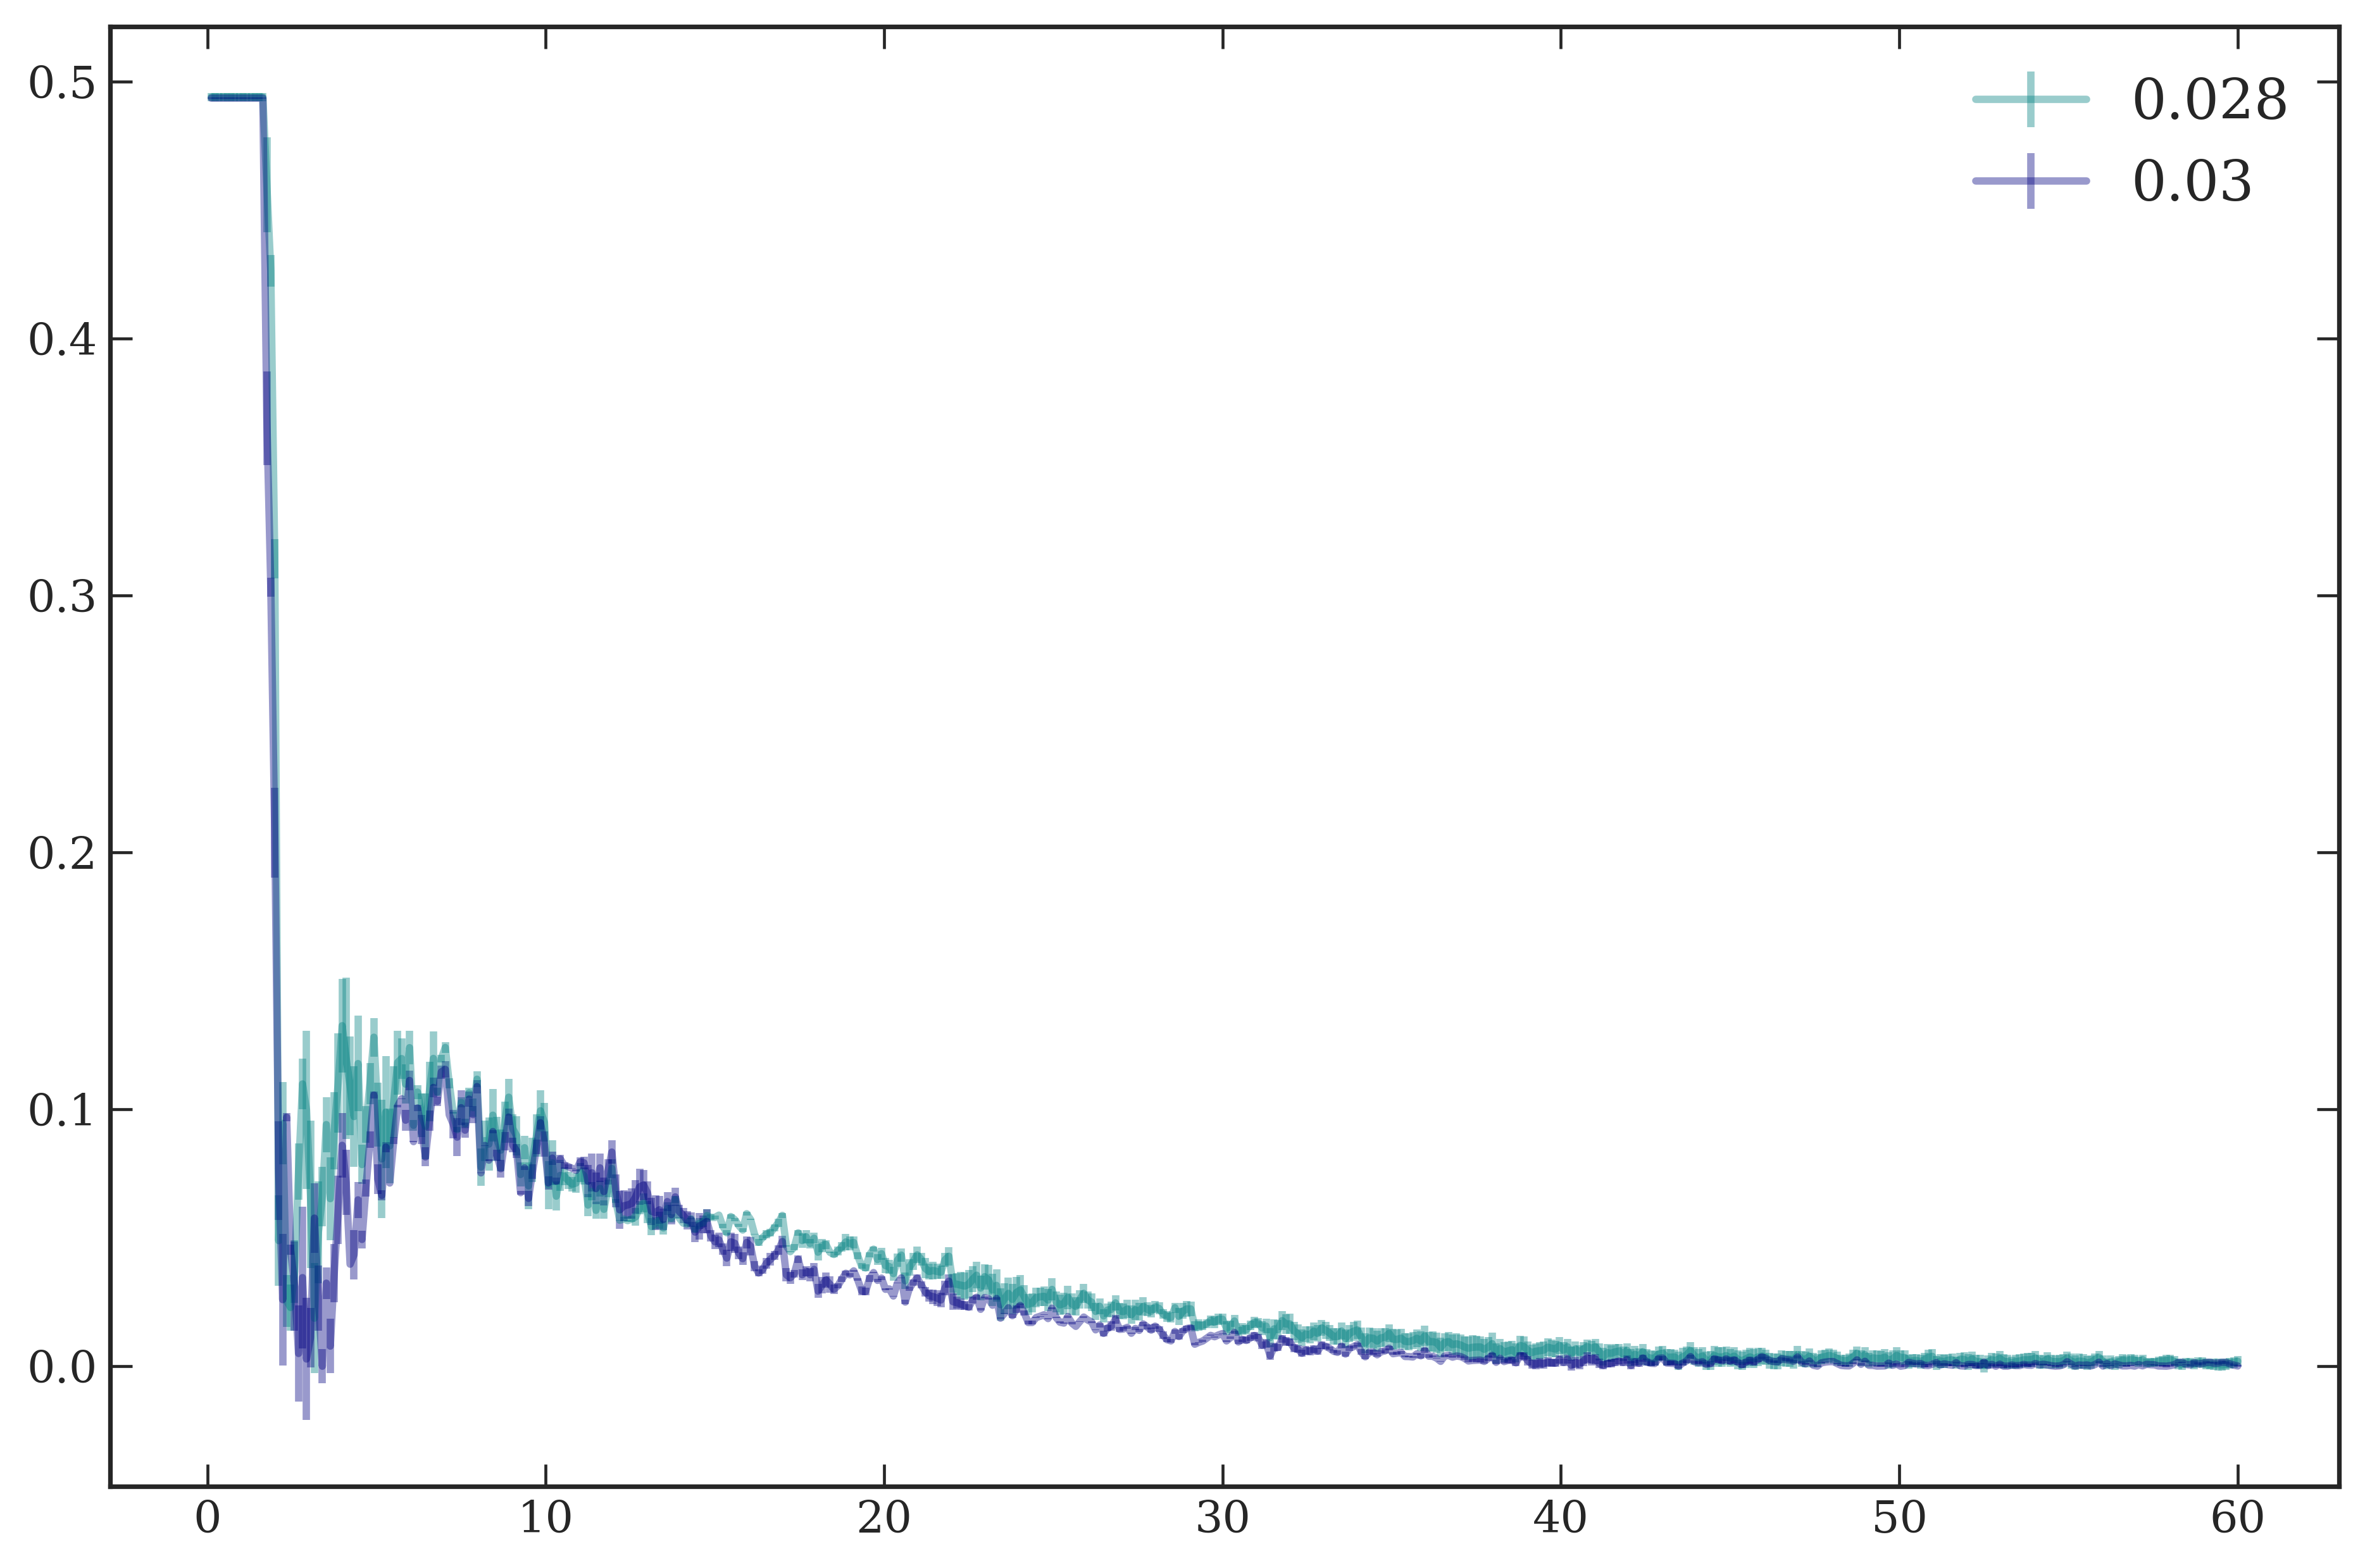

In [98]:

test = True
pcf_arr_list = []
#kest_kwargs = {'rmax': rmax, 'correction': 'best', 'nlarge': 'inf', 'var.approx': False}
if test:
    fig, ax = plt.subplots()
for act, dir in zip(activity_list[min_dir_idx:max_dir_idx], data_dirs[min_dir_idx:max_dir_idx]):
    save = False if test else True
    frame_interval = [0,2] if test else None
    if test:
        print(act, dir)
    with open(os.path.join(dir, 'defect_positions.pkl'), 'rb') as f:
        defect_list = pickle.load(f)
    rad_arr, pcf_arr = get_pair_corr_from_defect_list(defect_list, window, frame_idx_interval = frame_interval, method = "fv", \
                         kest_kwargs = kest_kwargs,\
                         method_kwargs = method_kwargs, save=save, save_dir=save_path,\
                              save_suffix=f'{act}rm{int(rmax)}_spar{spar}_nf{Nframes}')
    pcf_arr_list.append(pcf_arr)
    if test:
      #  ax.plot(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1), label=f'{act}')
        ax.errorbar(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1),\
             np.abs(np.nanstd(pcf_arr, axis=0)), label=f'{act}', alpha=.4)
if test:
    ax.legend()

In [105]:
len(defect_list)

181

In [112]:
arr = get_defect_arr_from_frame(defect_list[0])
arr.shape

(2914, 2)

In [121]:
from rdfpy import rdf

gr, rad = rdf(arr, dr=0.1, rcutoff=0.15)

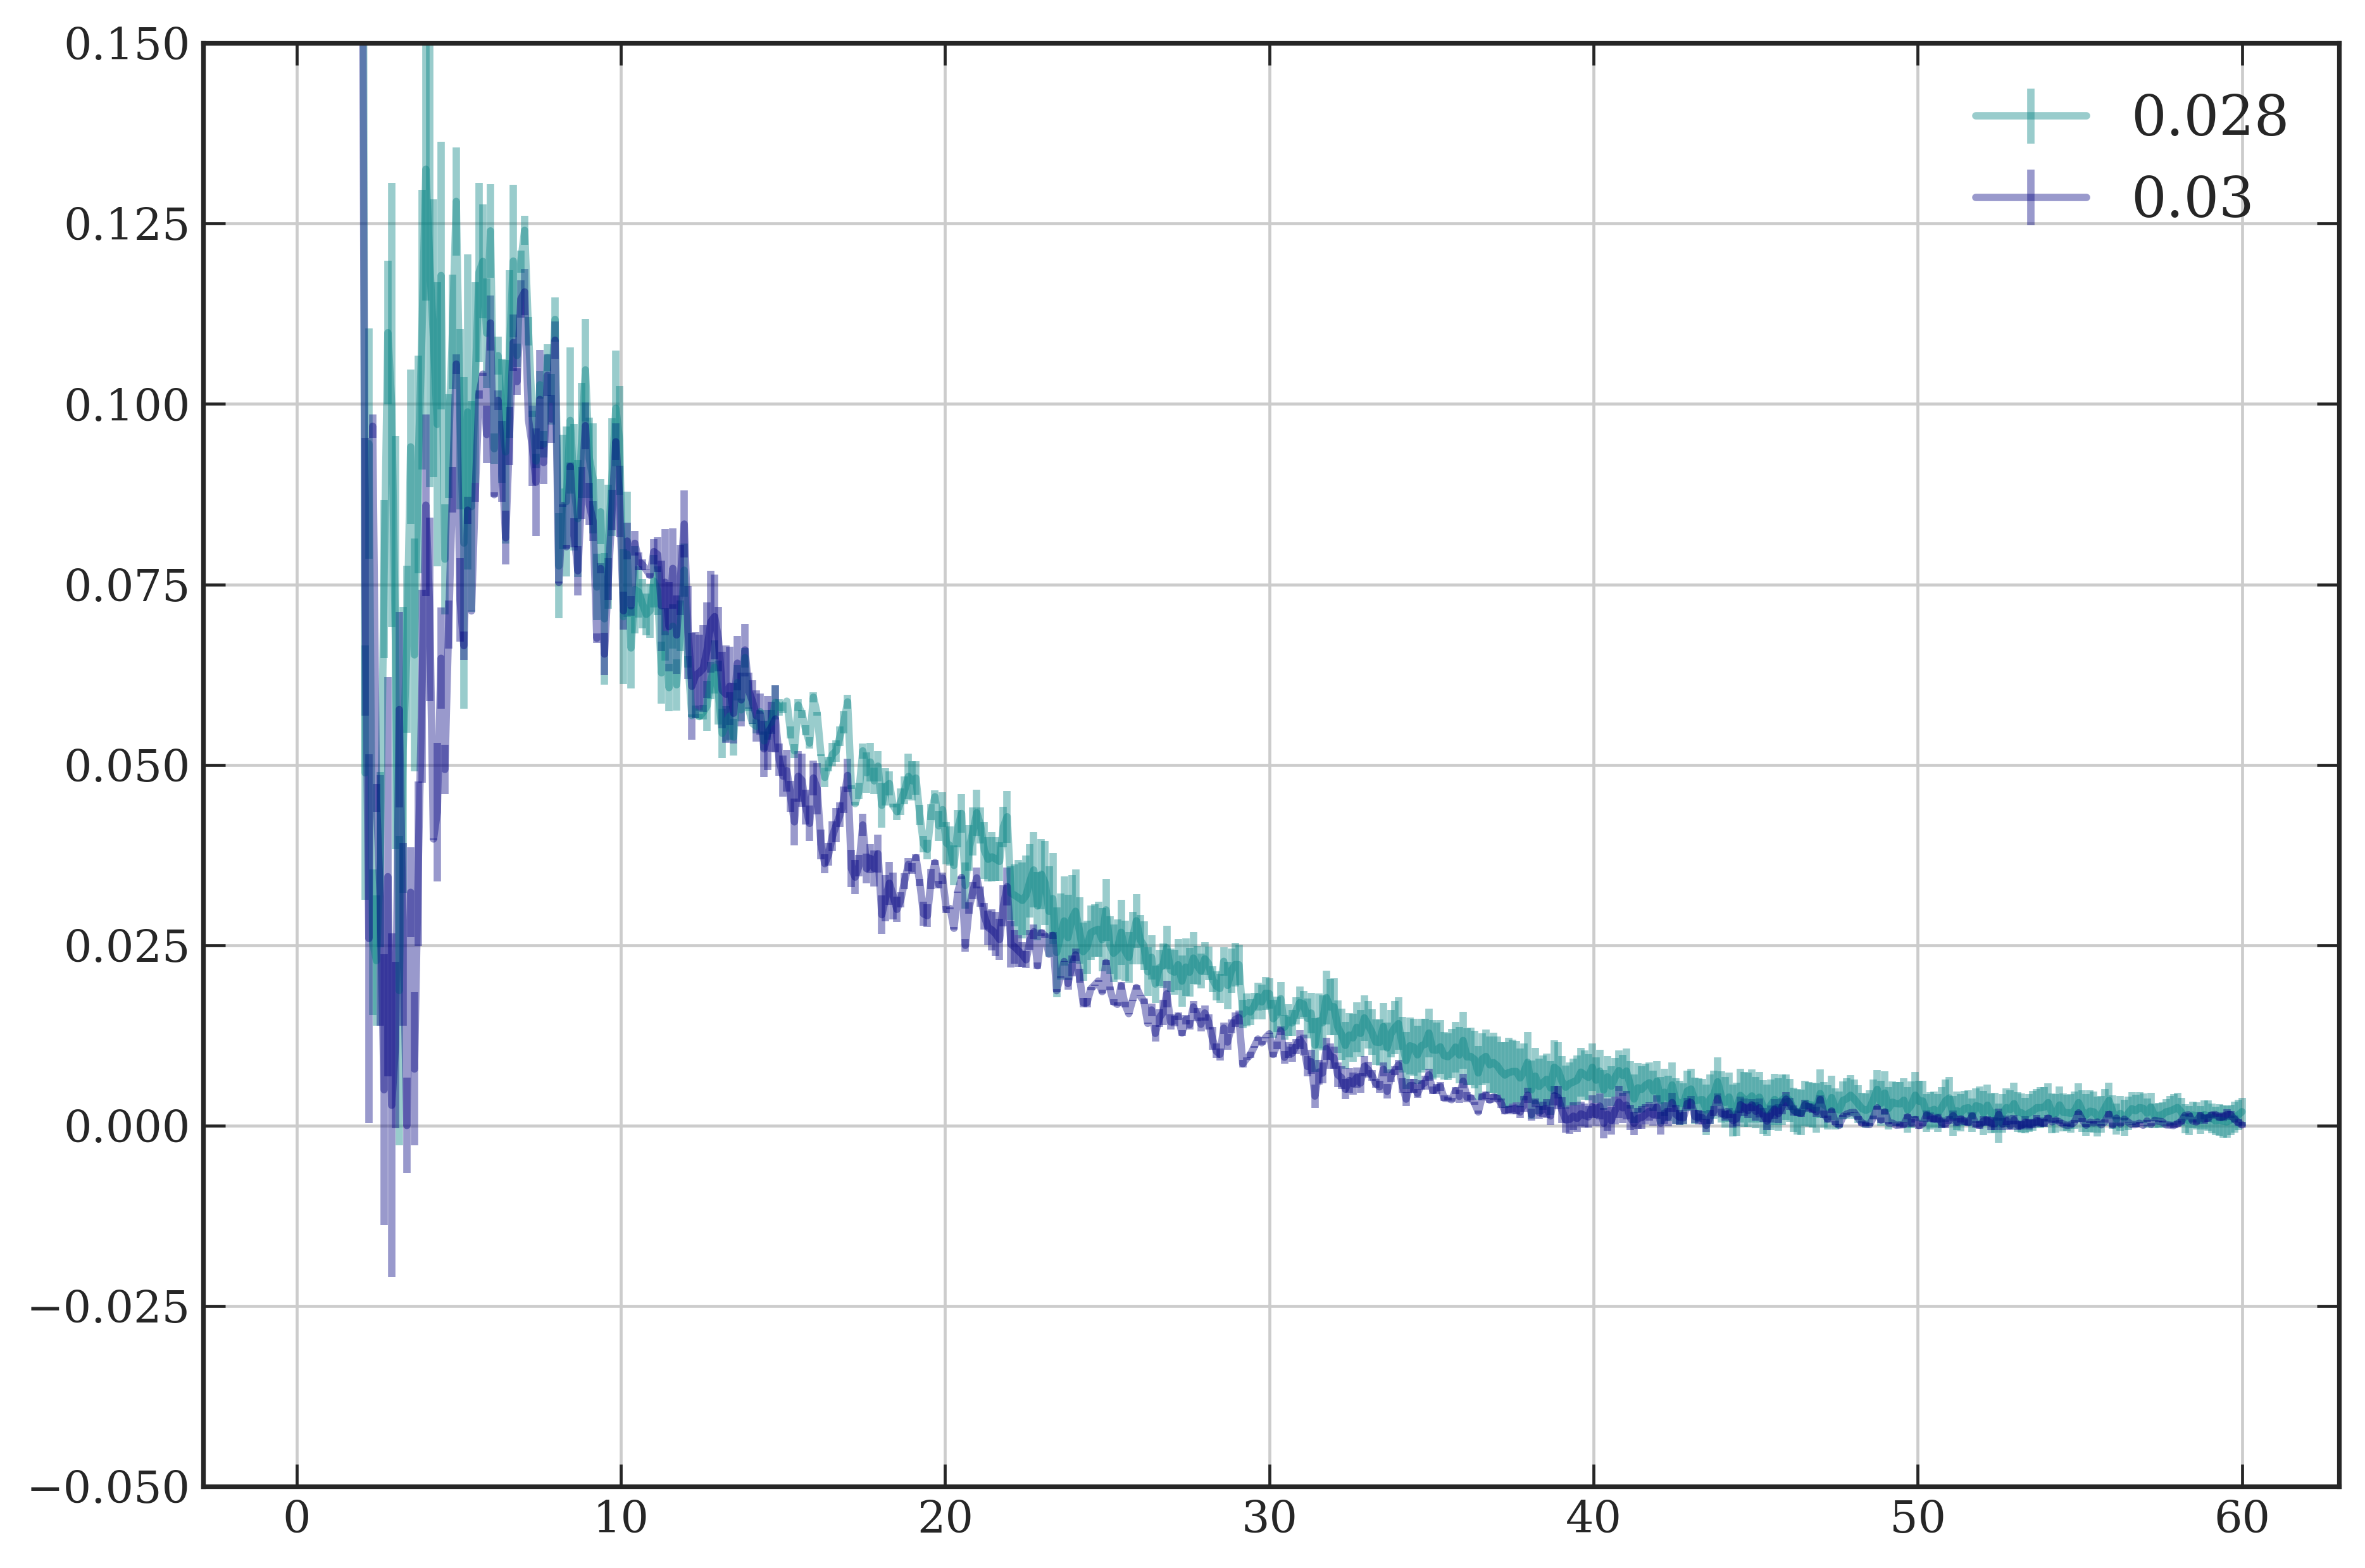

In [96]:

ax.set(ylim=[-.05, .15])
#knots 30 rm 60 spar 1.2
ax.grid(True)
fig

In [ ]:
ax.set(ylim=[-.05, .15])
#knots 25 rm 50 spar 1.2
ax.grid(True)
fig

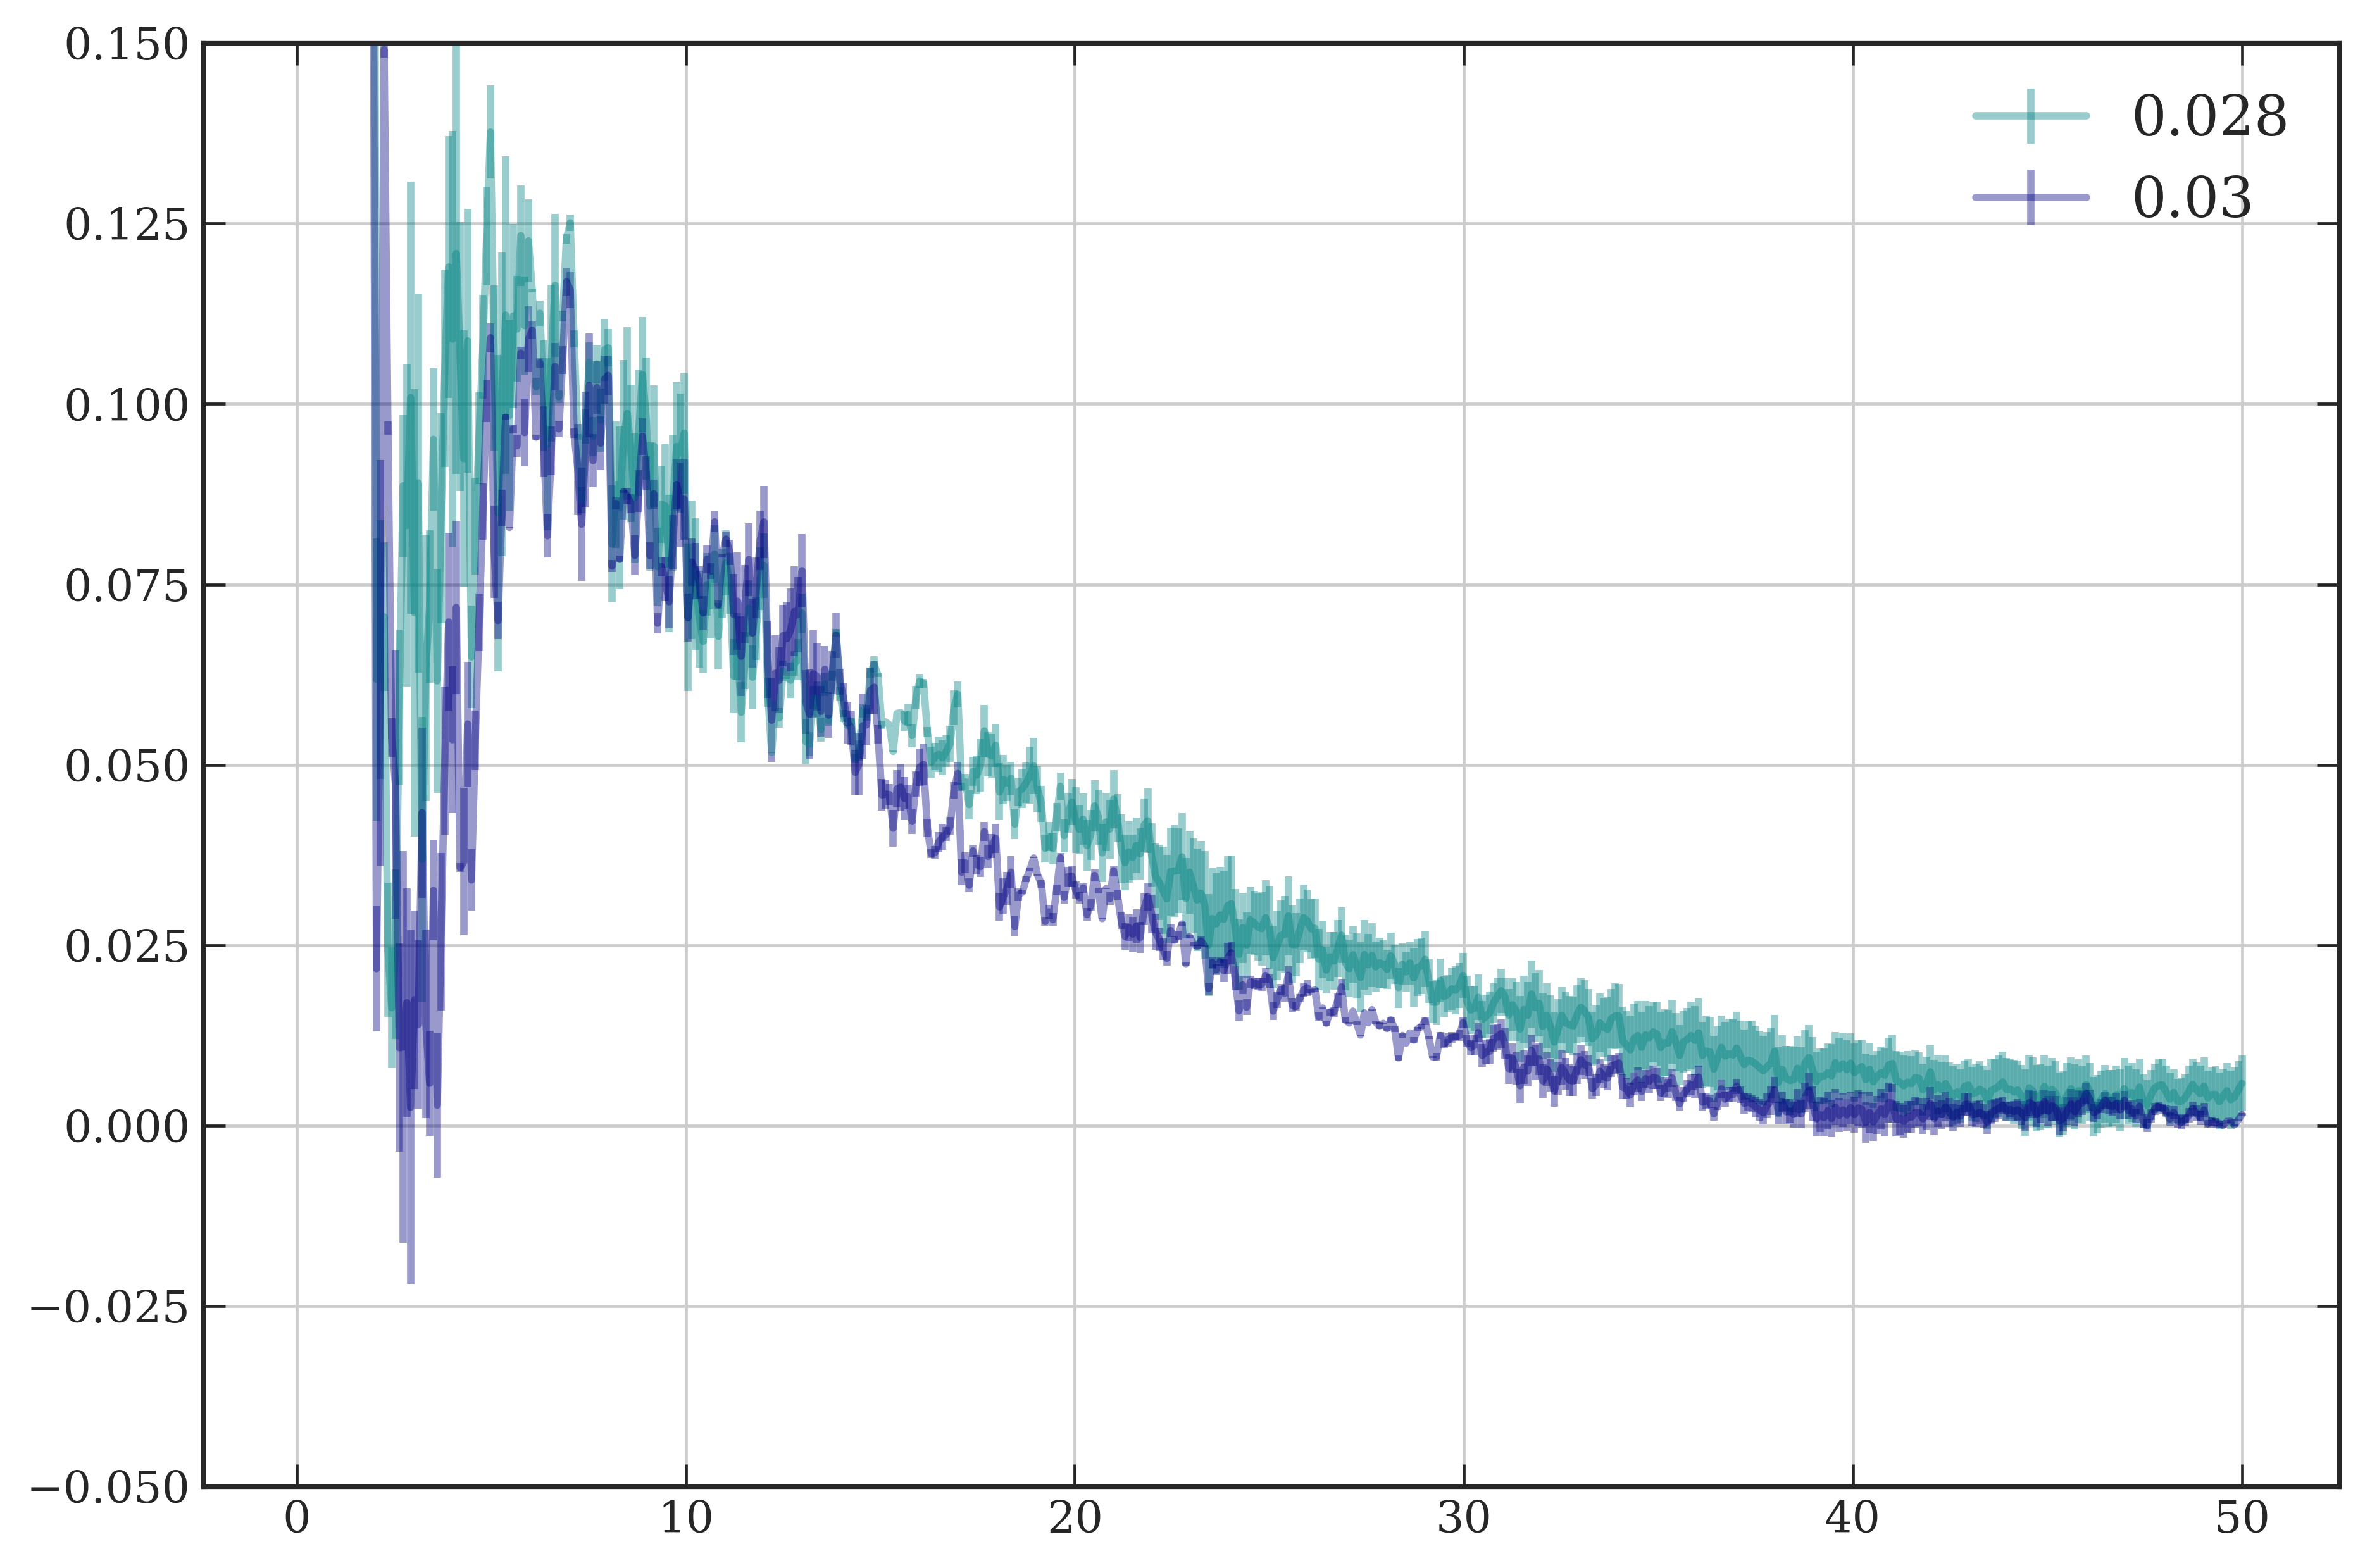

In [86]:
ax.set(ylim=[-.05, .15])
#knots 25 rm 50 spar 1.2
ax.grid(True)
fig

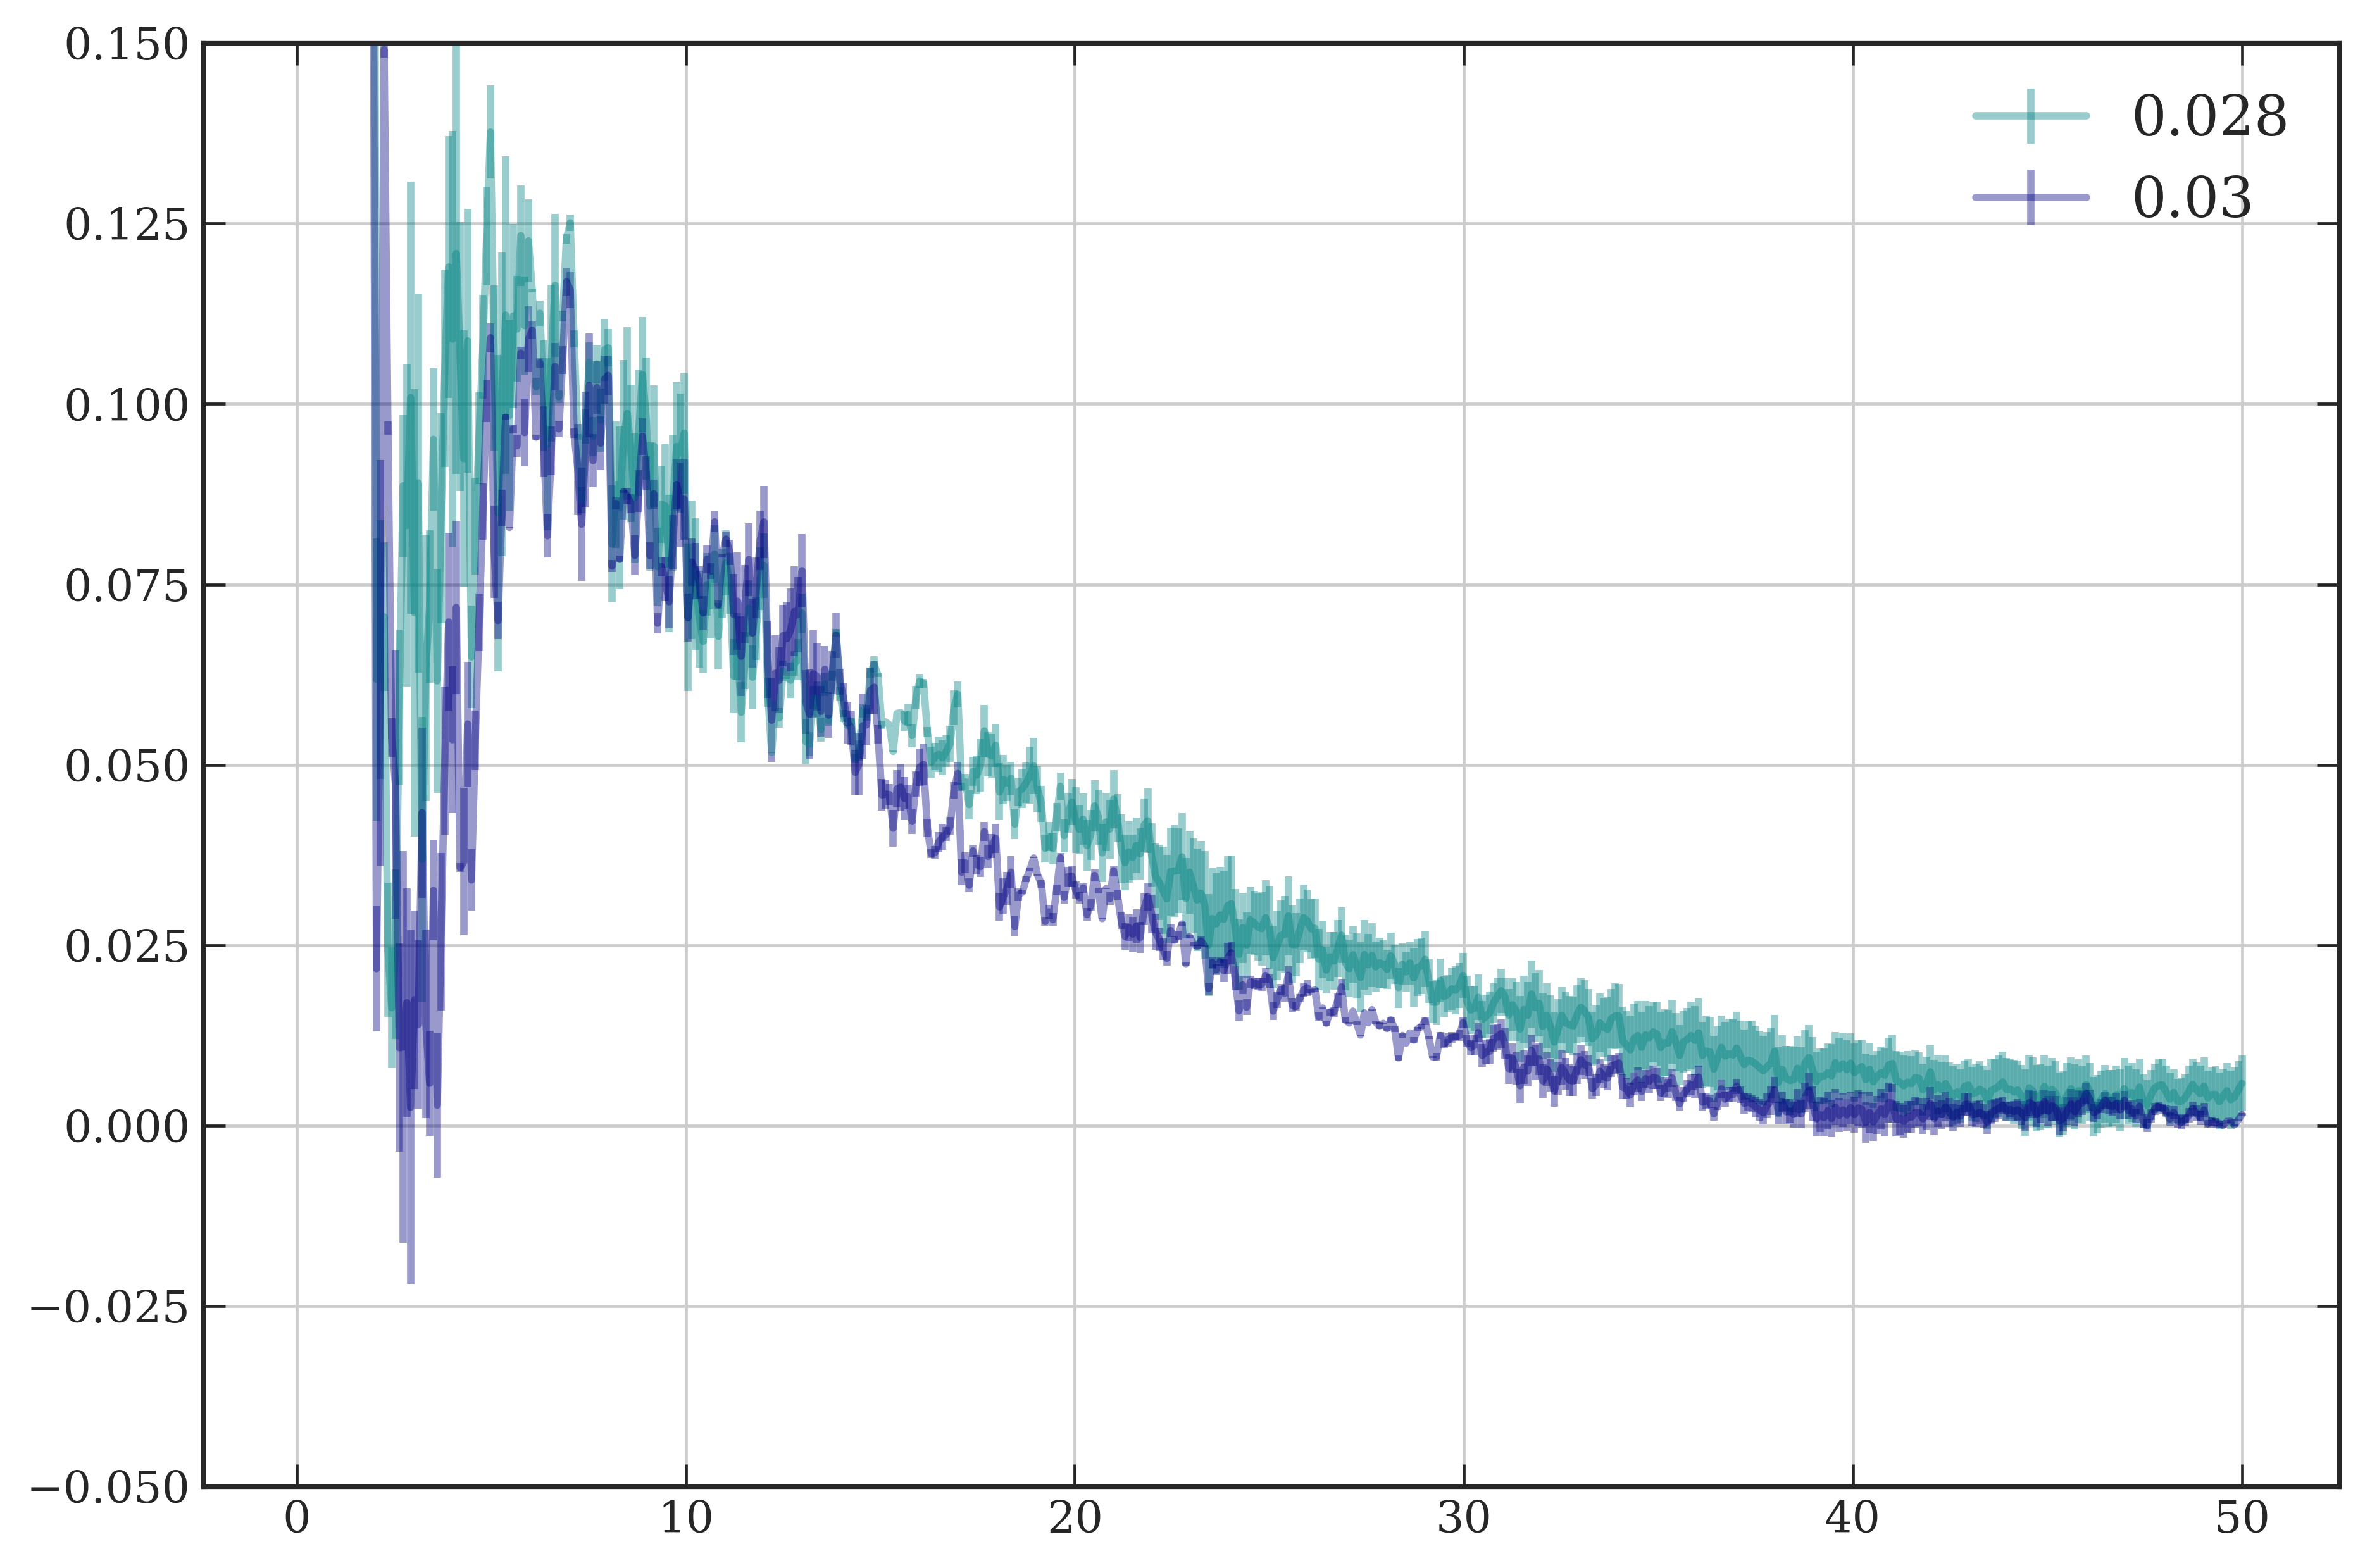

In [79]:
ax.set(ylim=[-.05, .15])
ax.grid(True)
fig # rmax 50 knots 50 spar 1.2

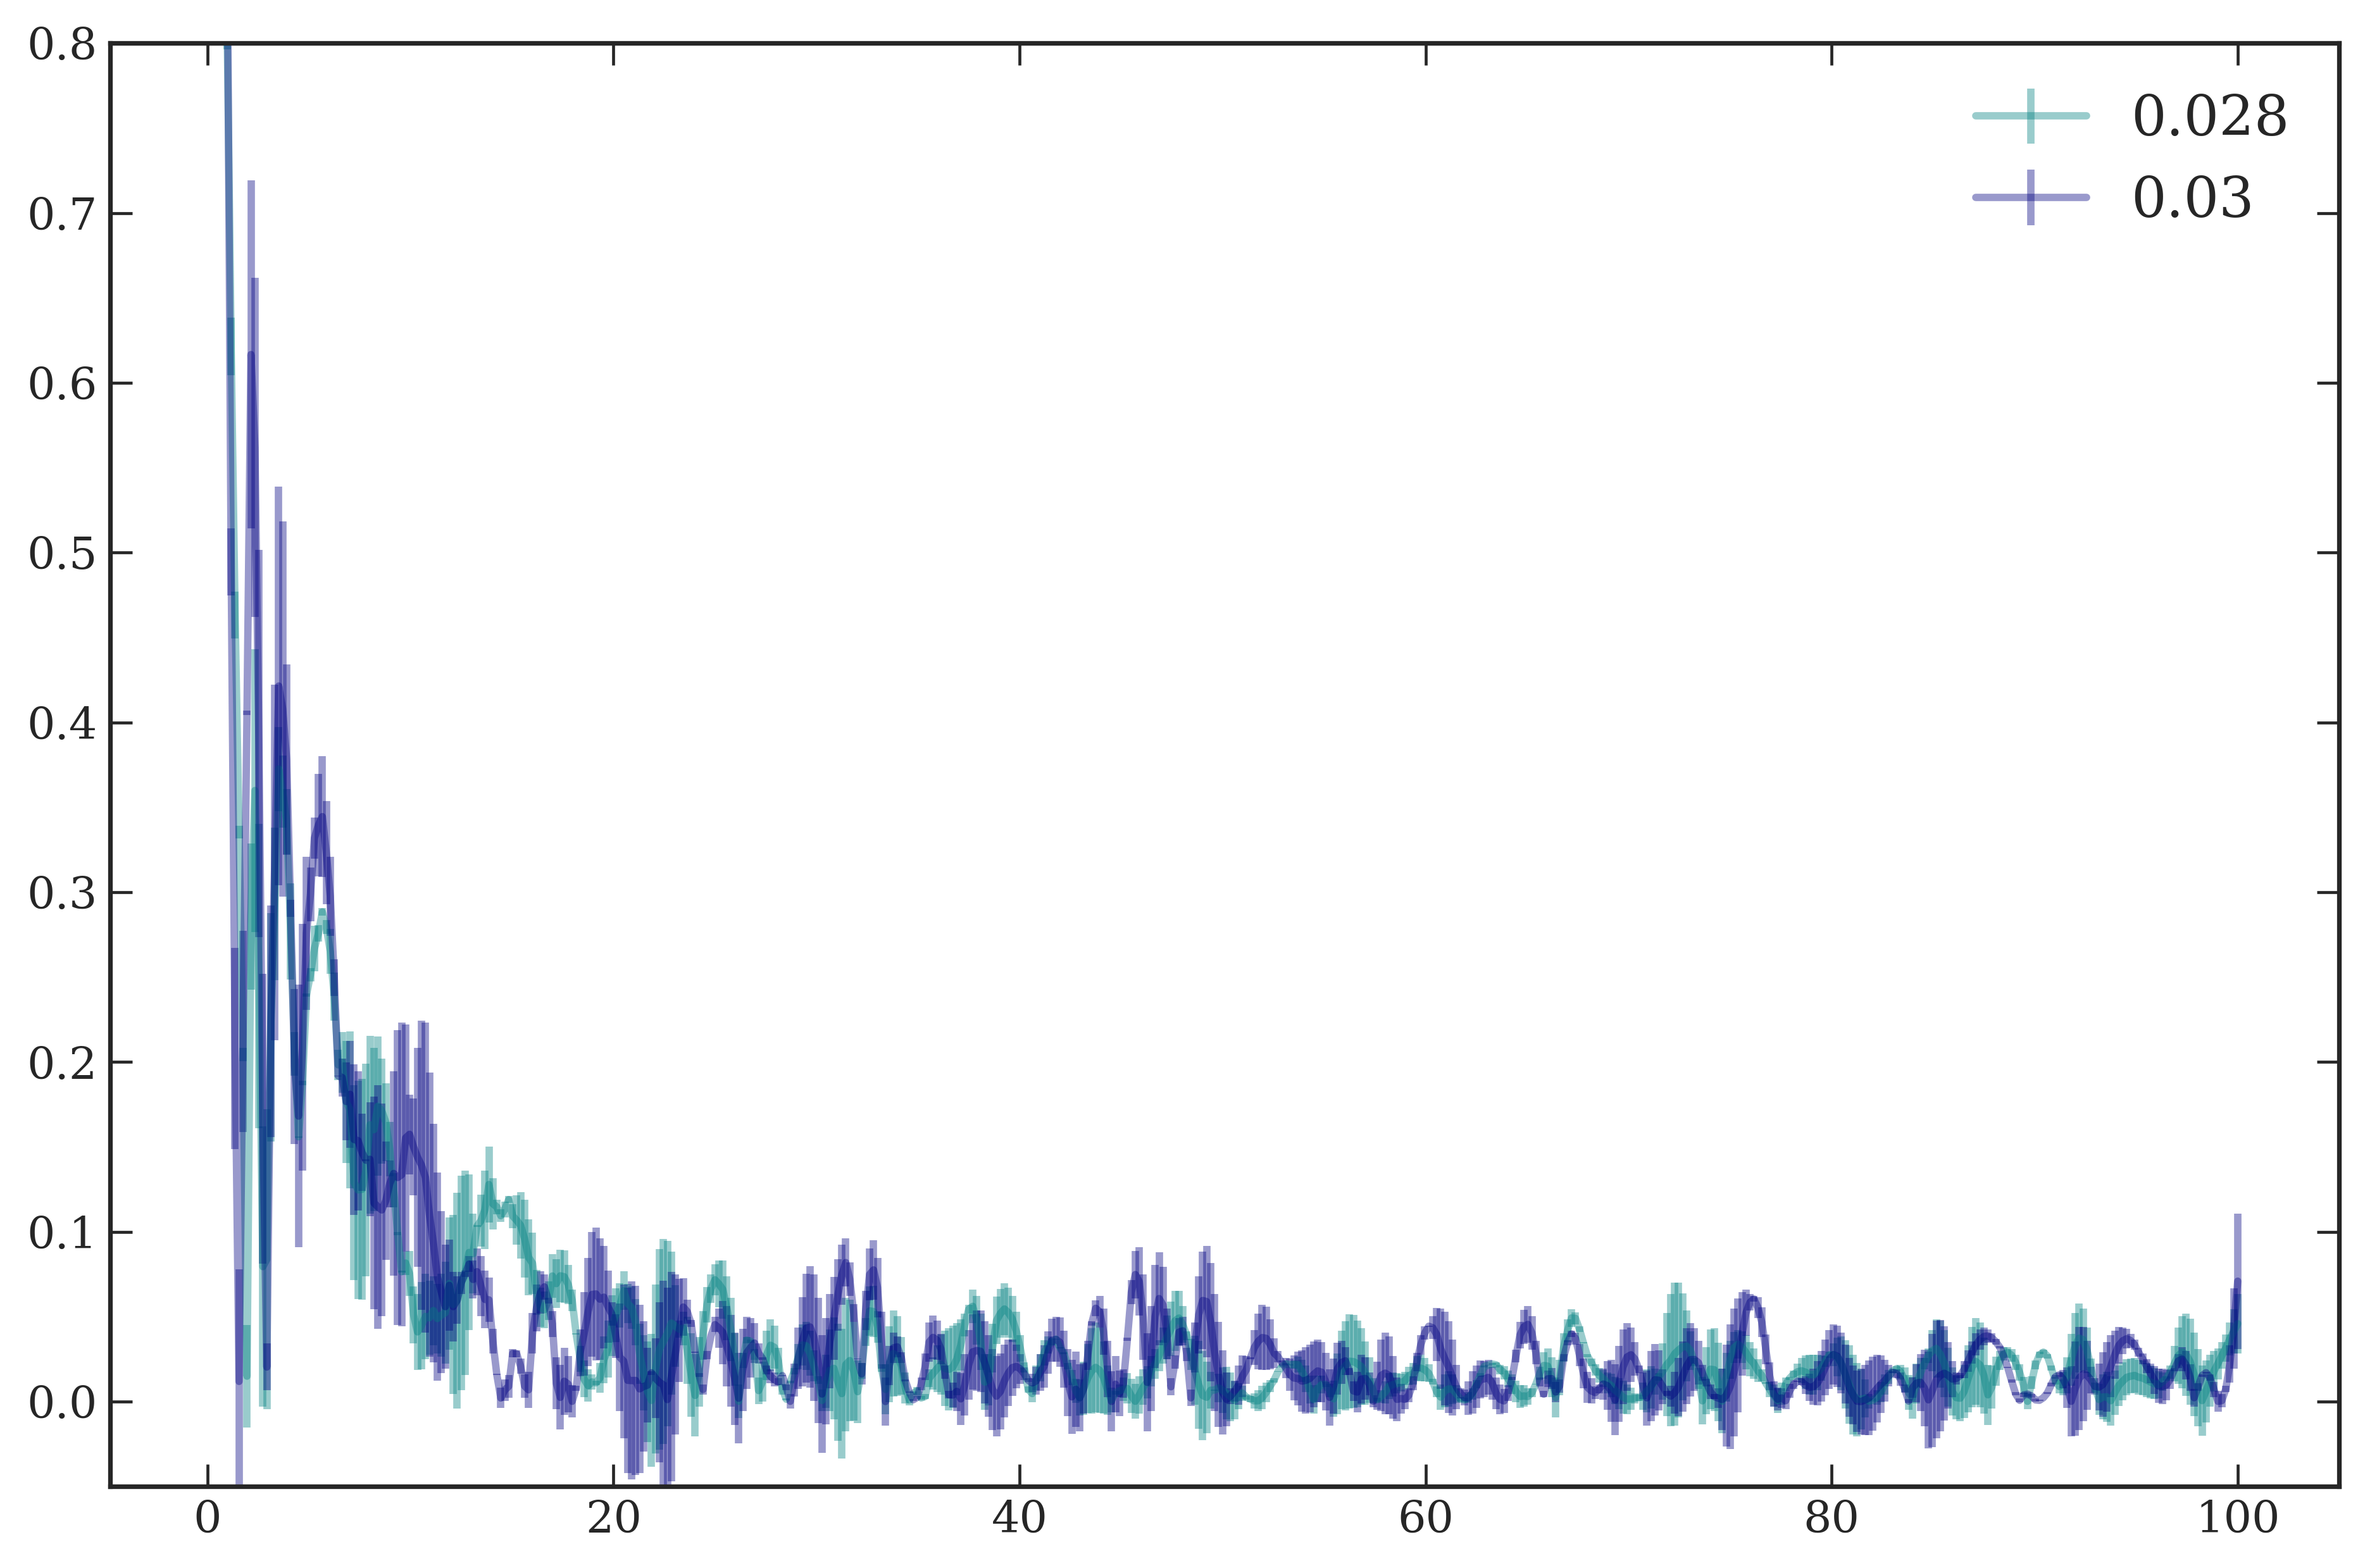

In [65]:
ax.set(ylim=[-.05, .8])
fig #knots=100 spar var

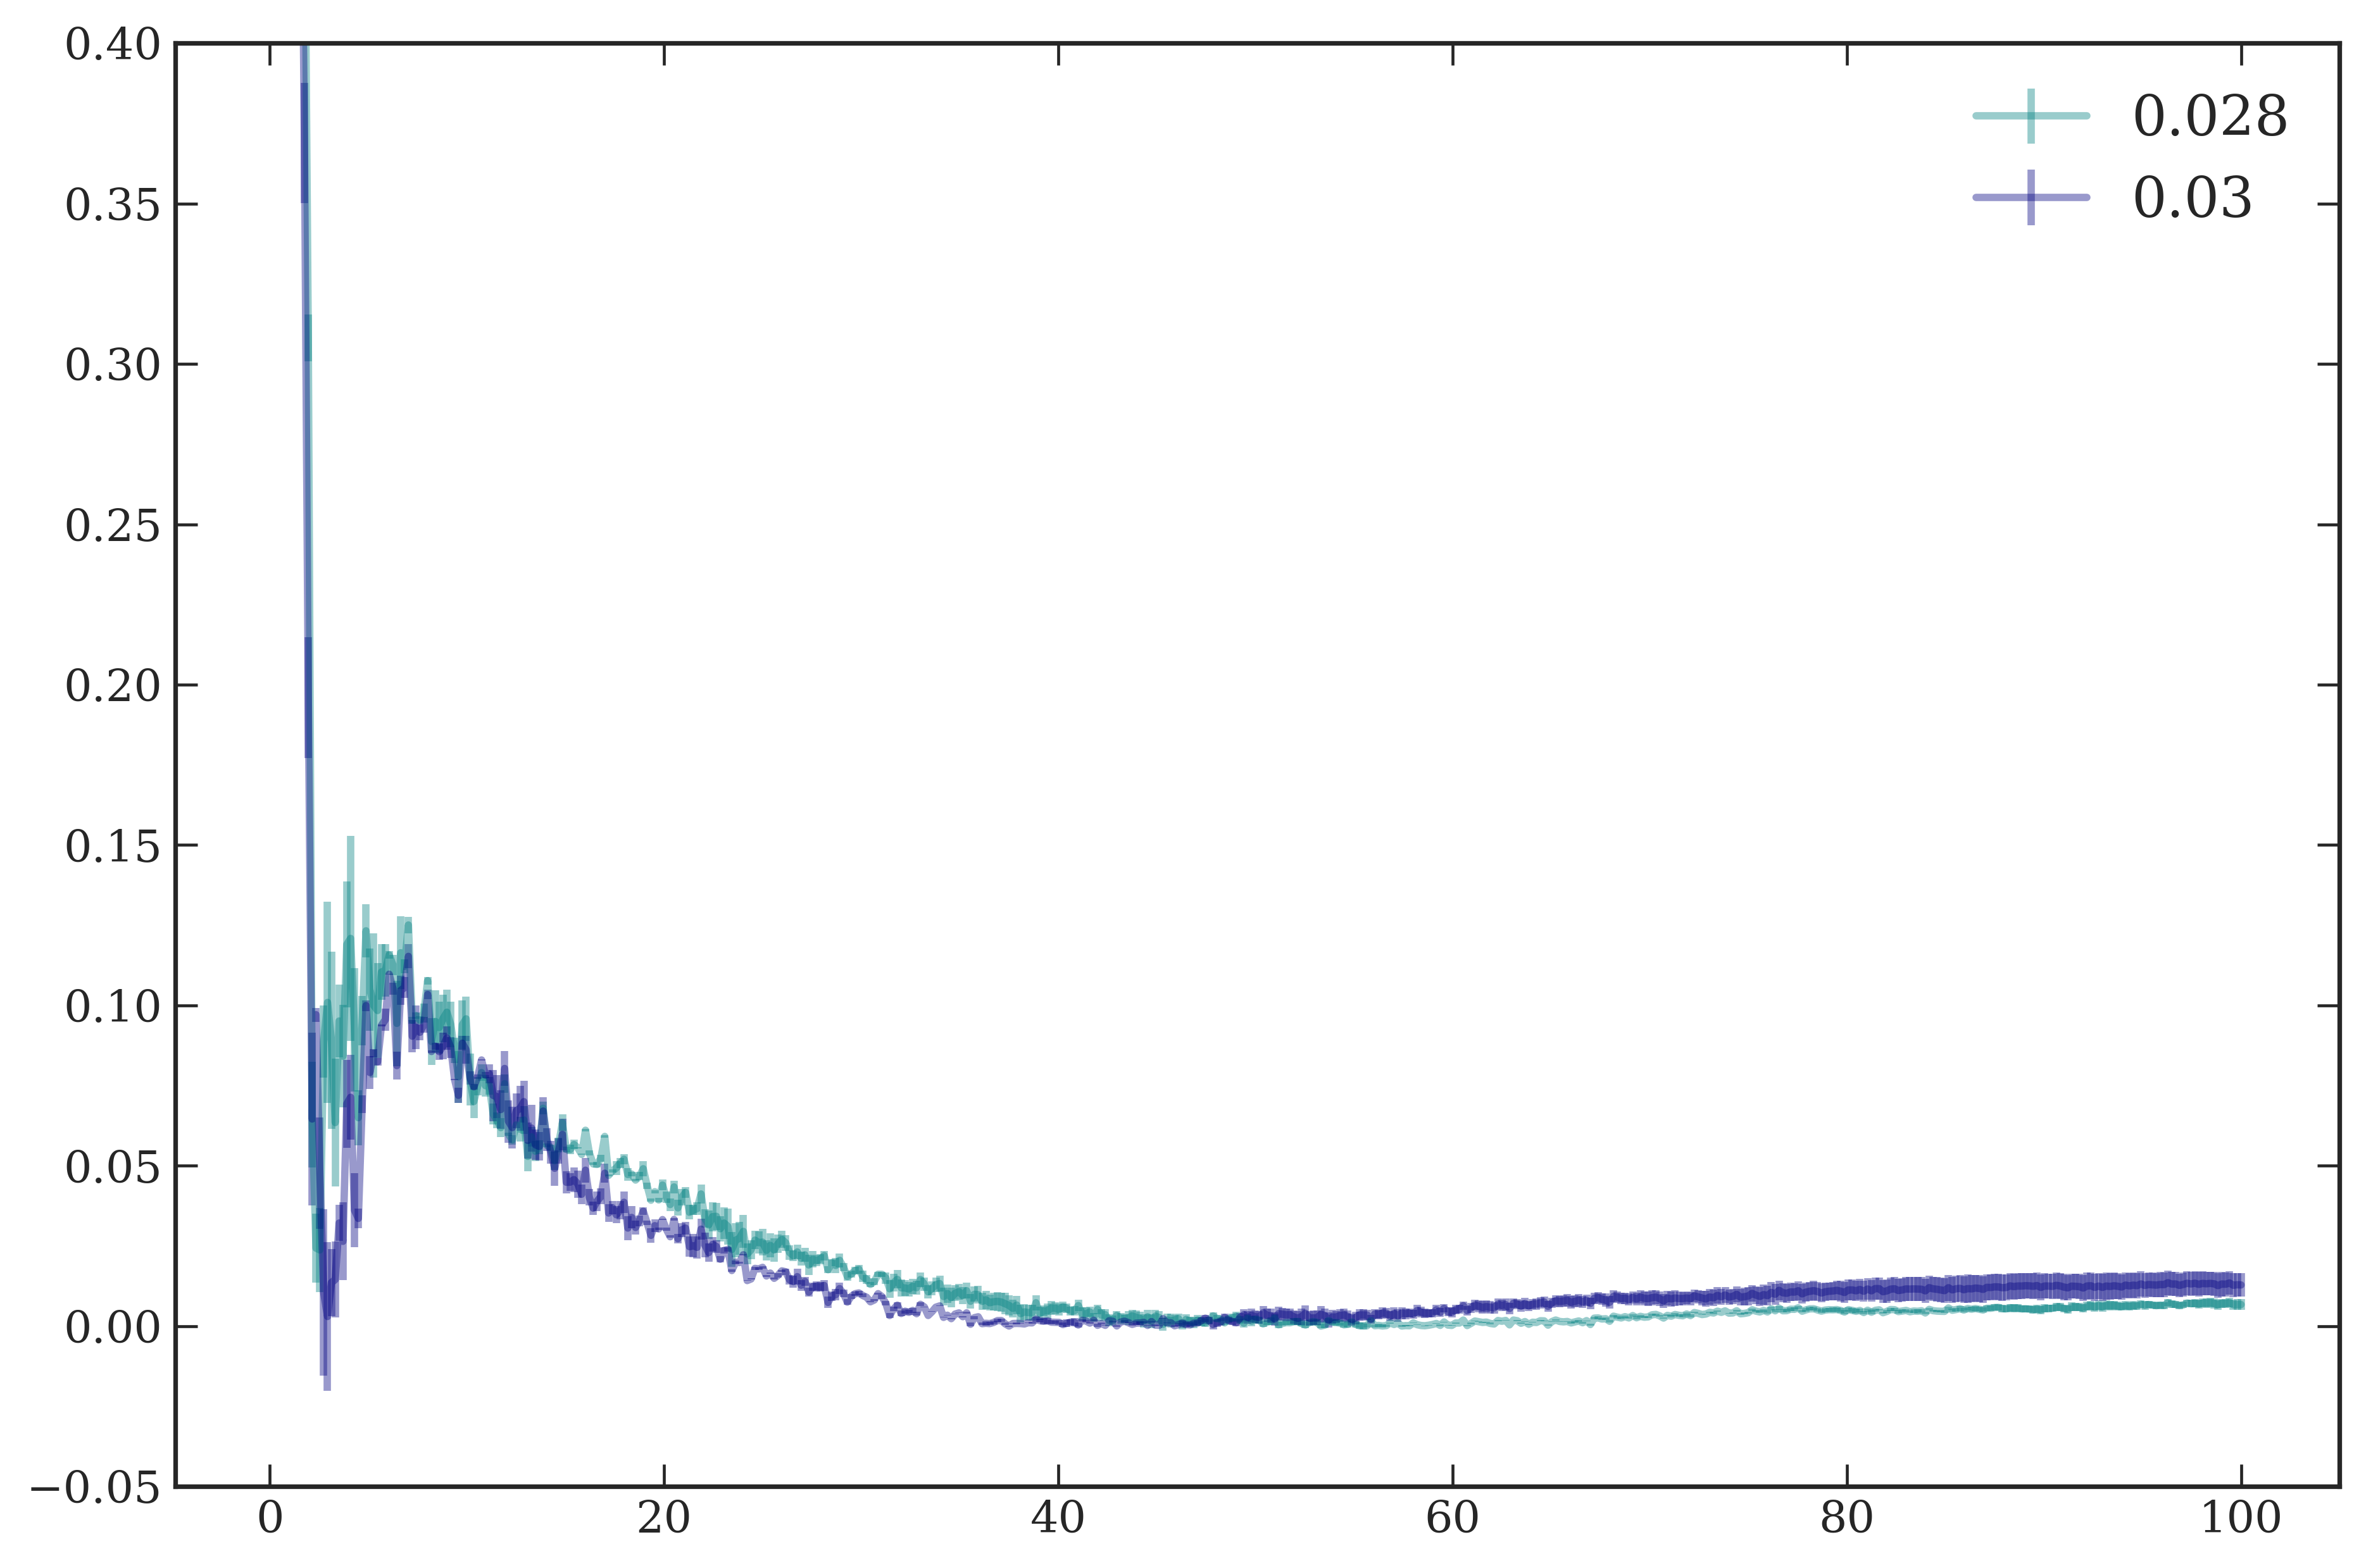

In [62]:
ax.set(ylim=[-.05, .4])
fig #knots=100 spar 1.2

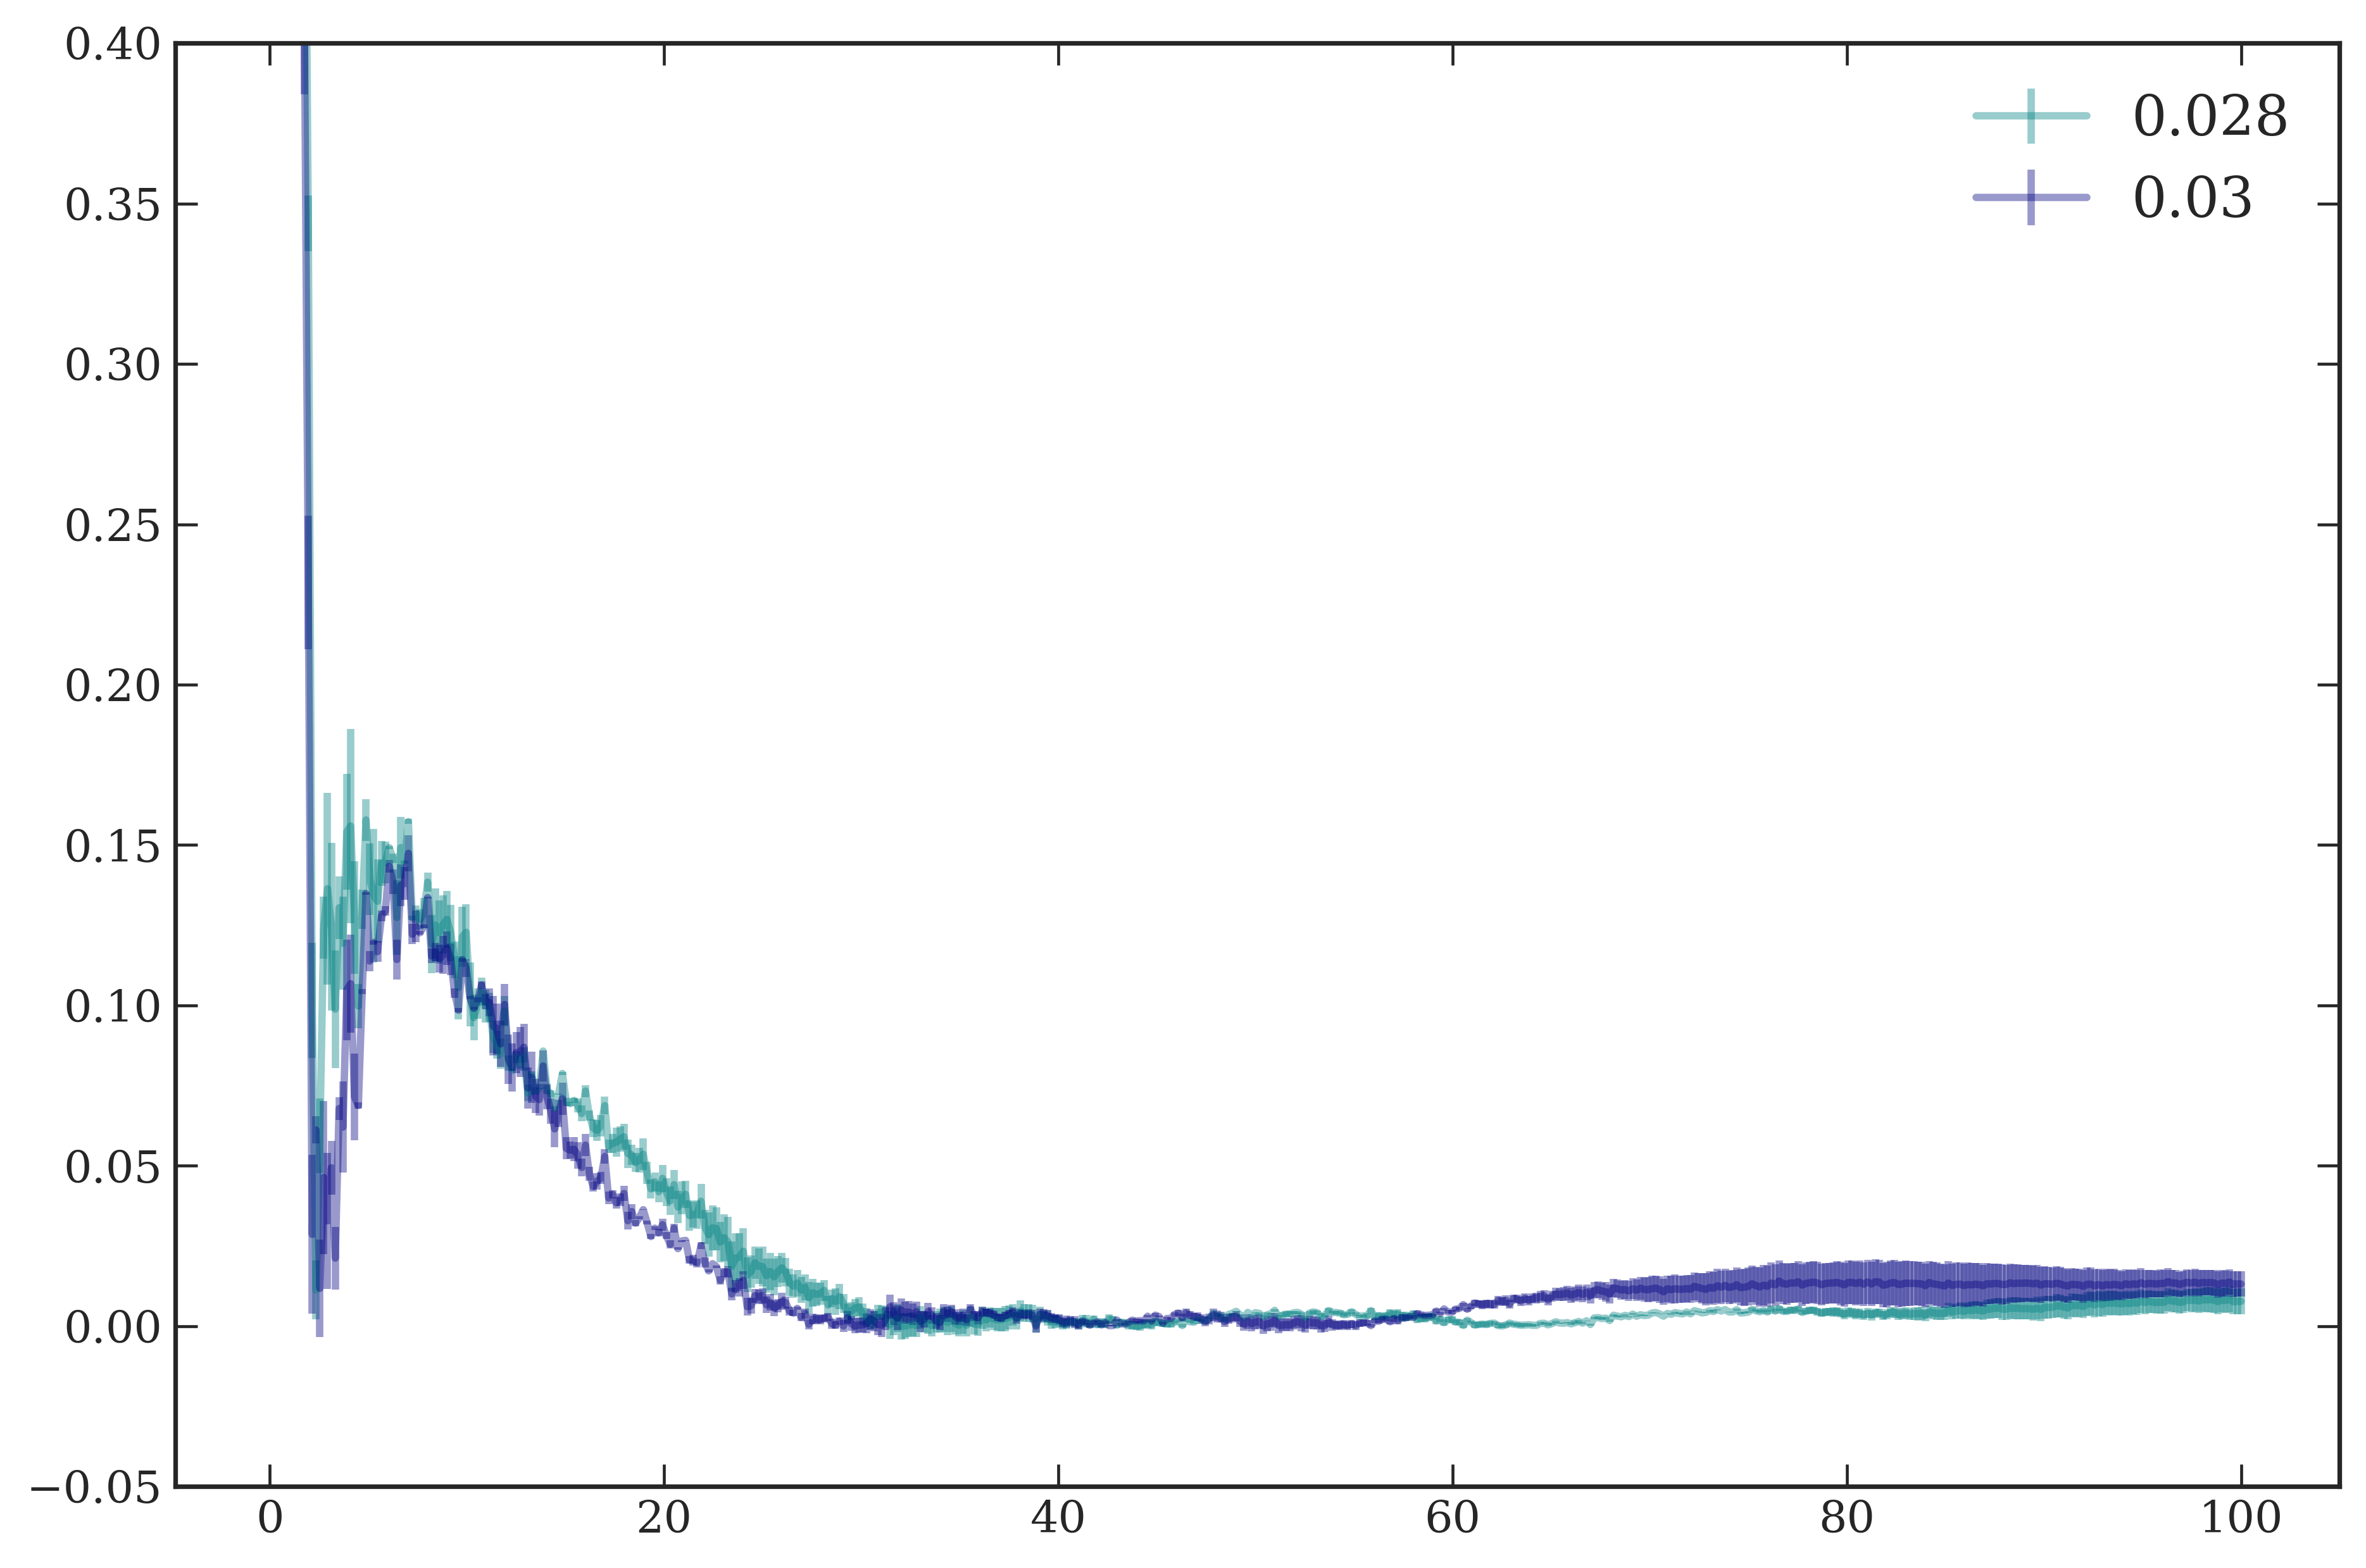

In [59]:
ax.set(ylim=[-.05, .4])
fig #knots=500 spar 1.3

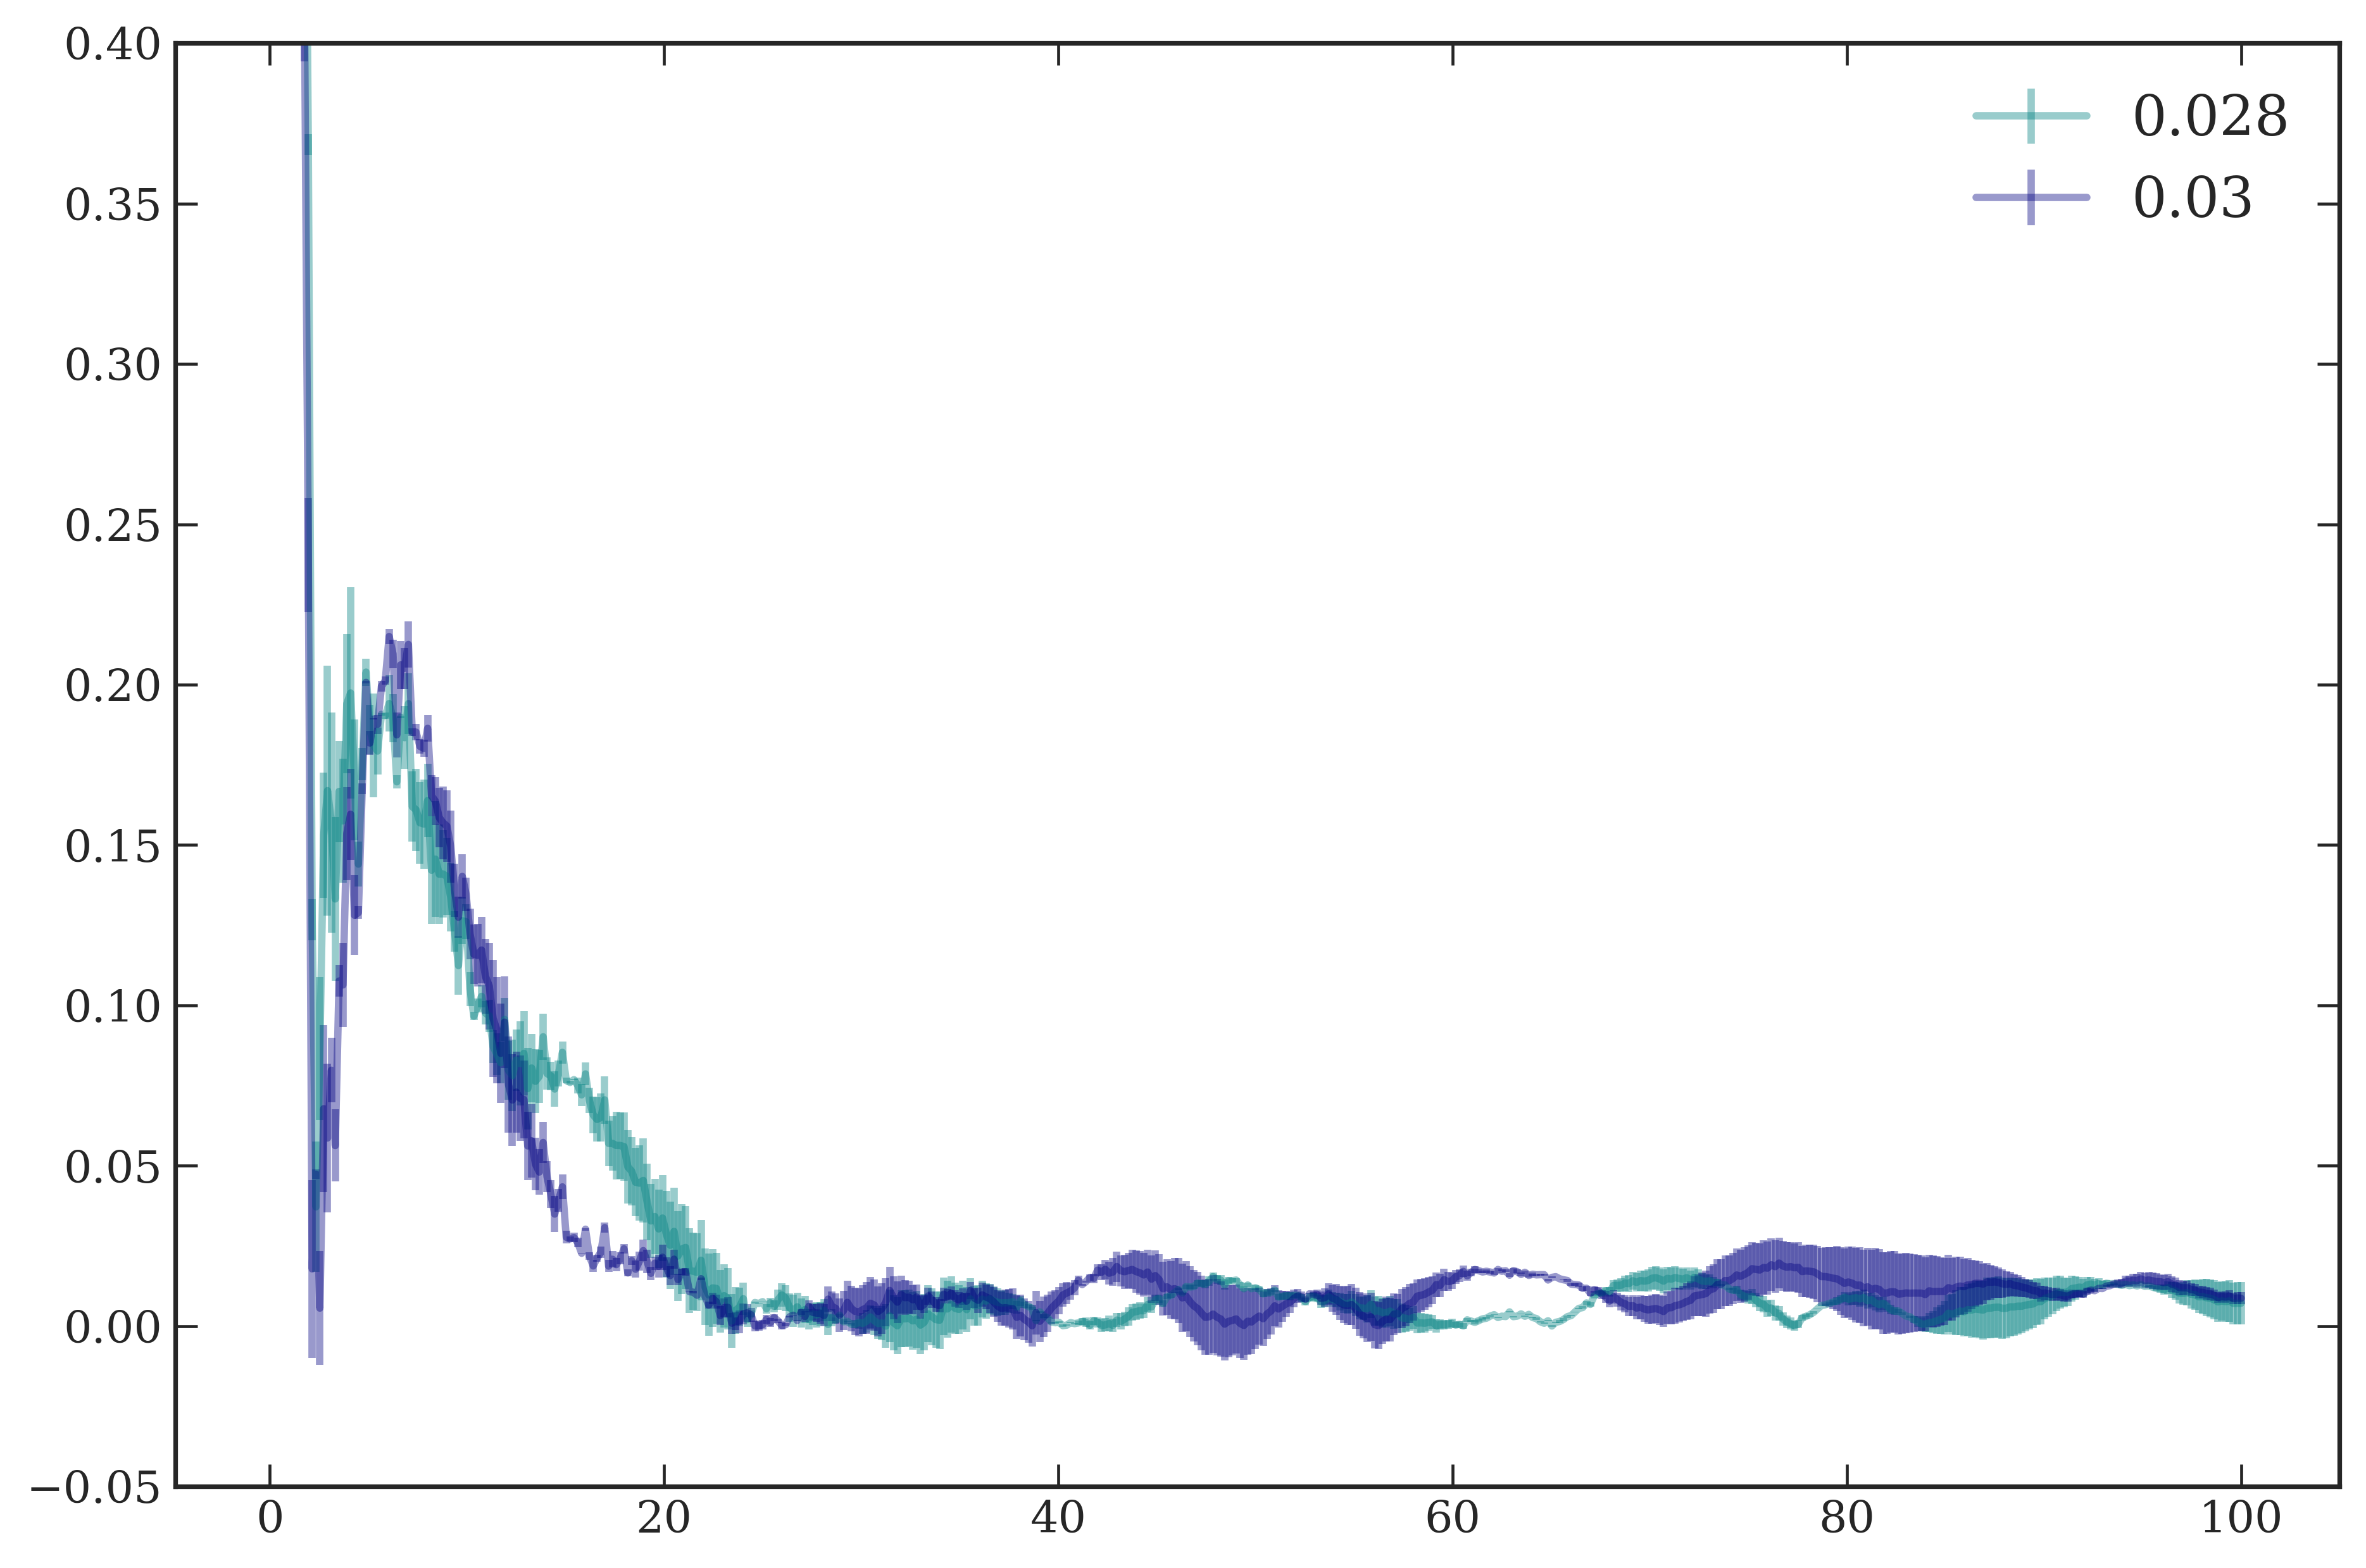

In [56]:
ax.set(ylim=[-.05, .4])
fig #knots=500 spar 1

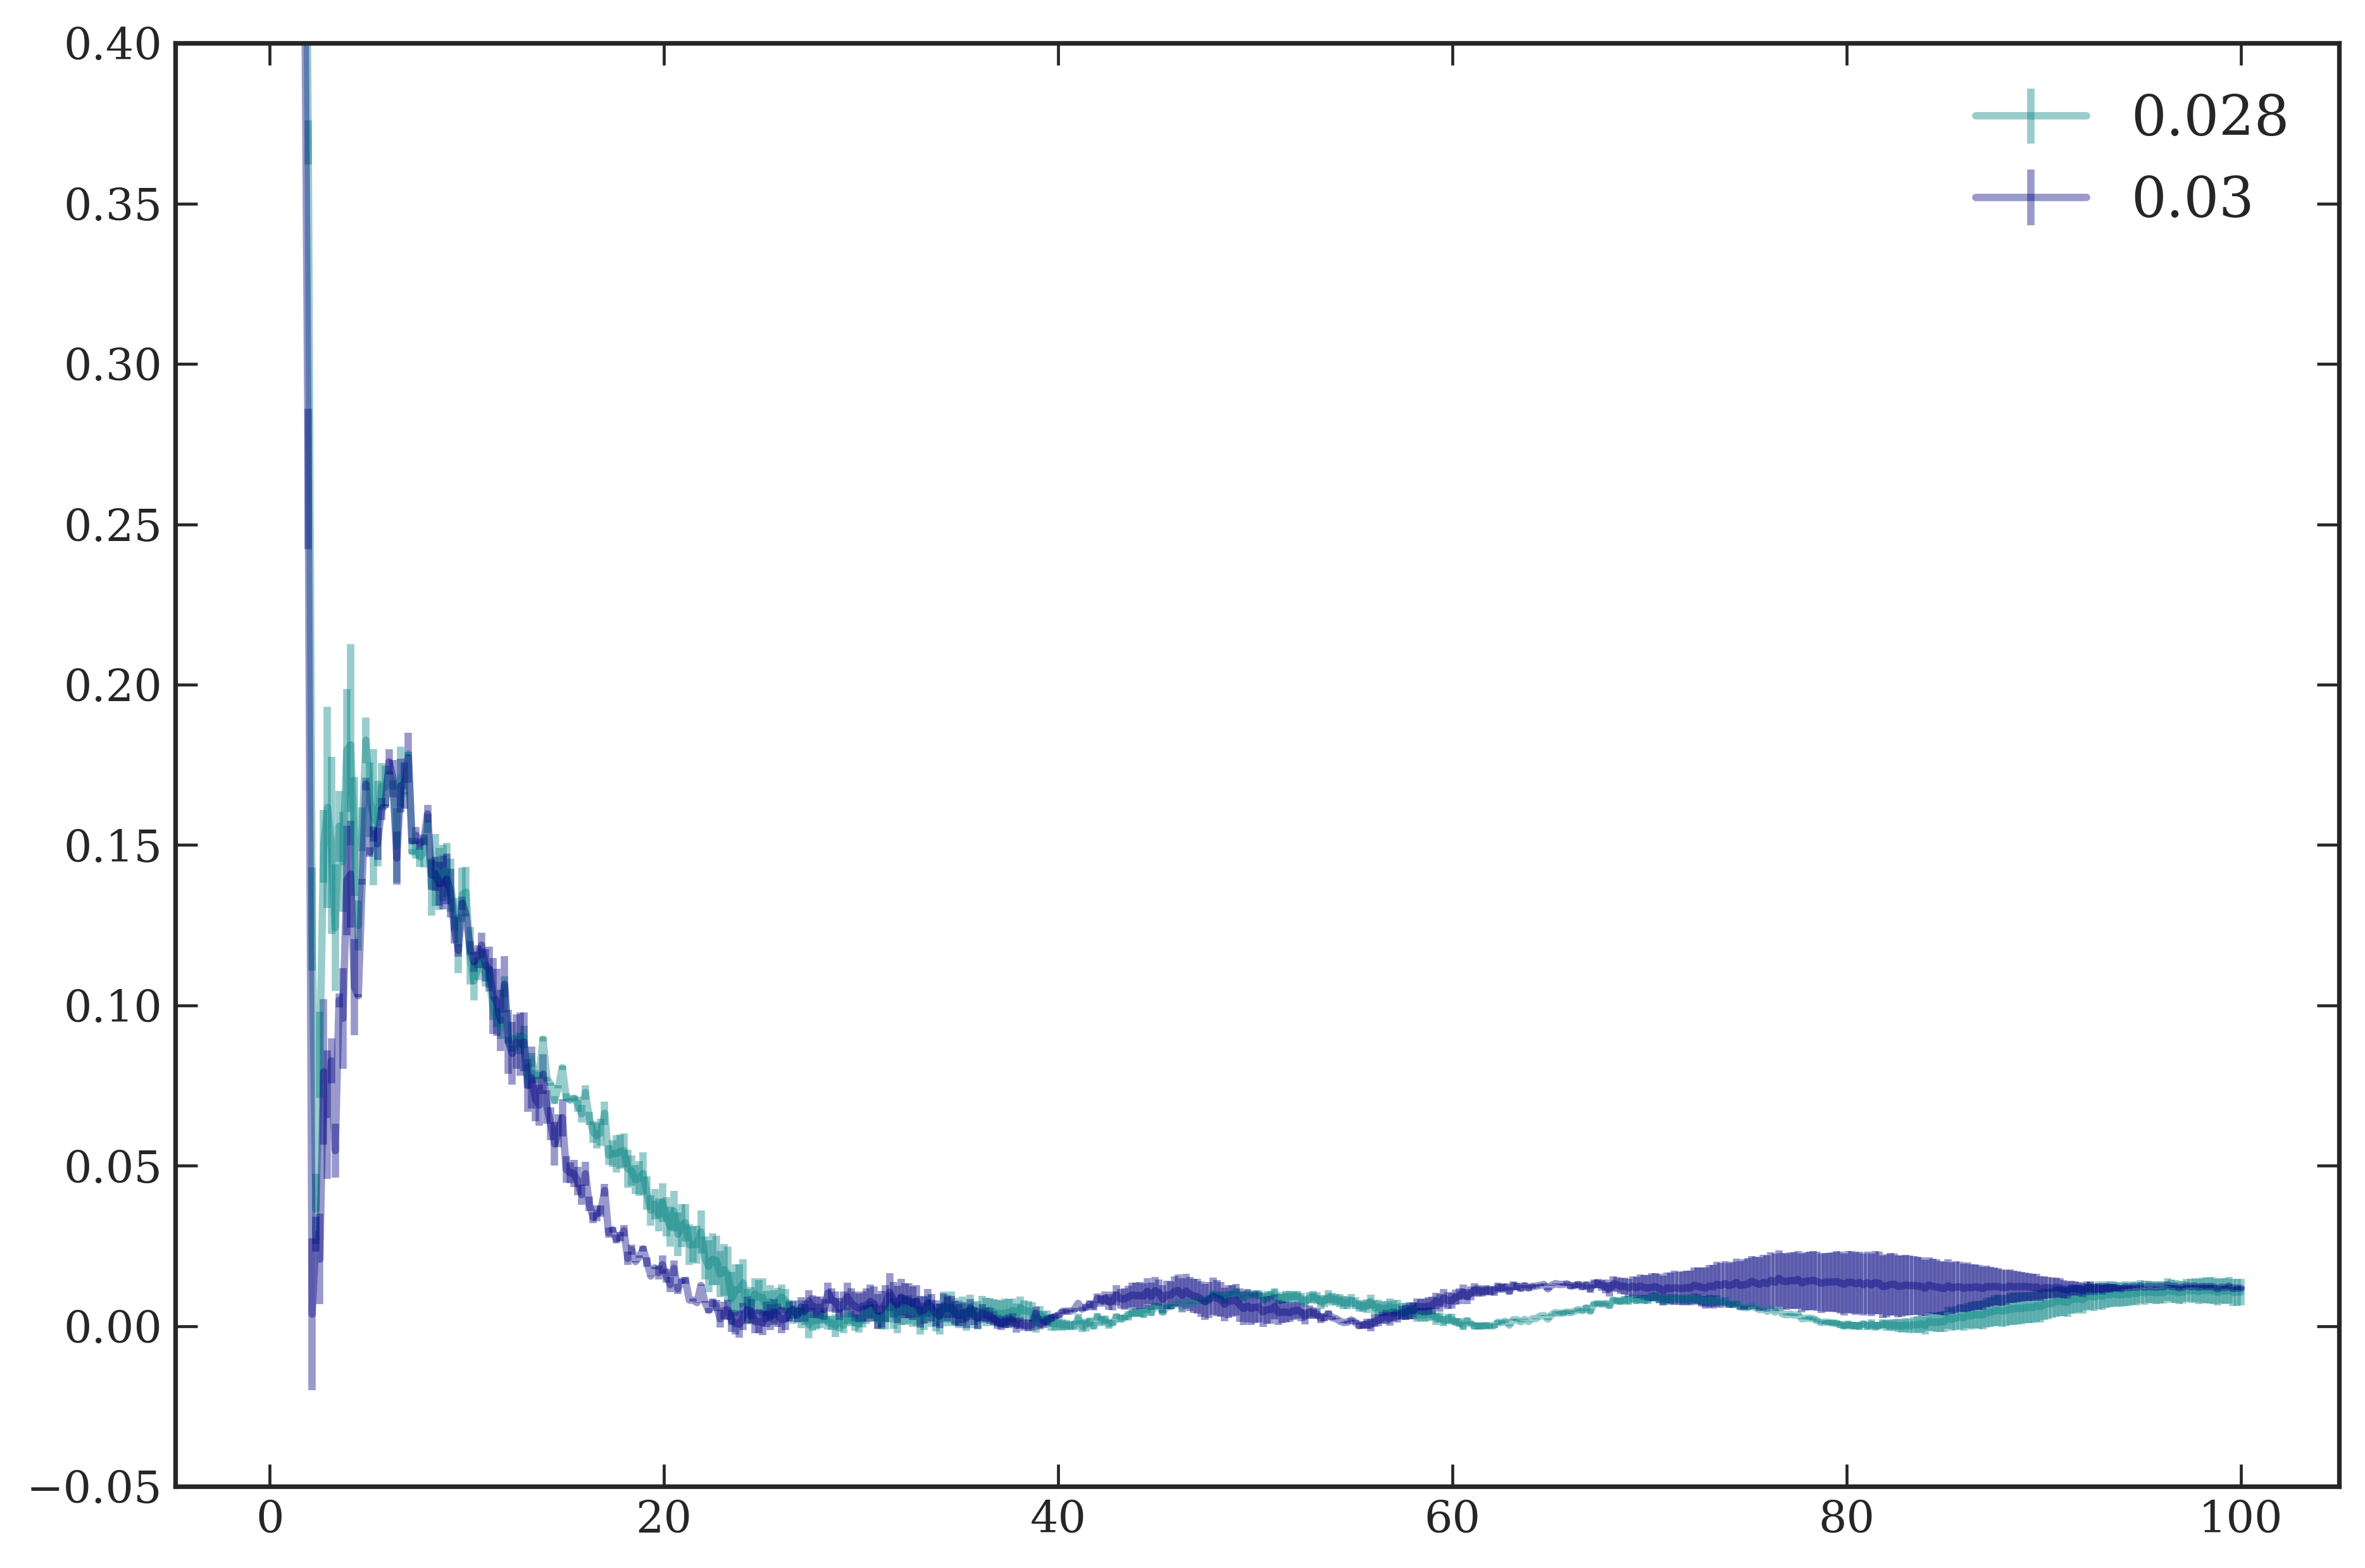

In [53]:
ax.set(ylim=[-.05, .4])
fig #knots=250 spar 1

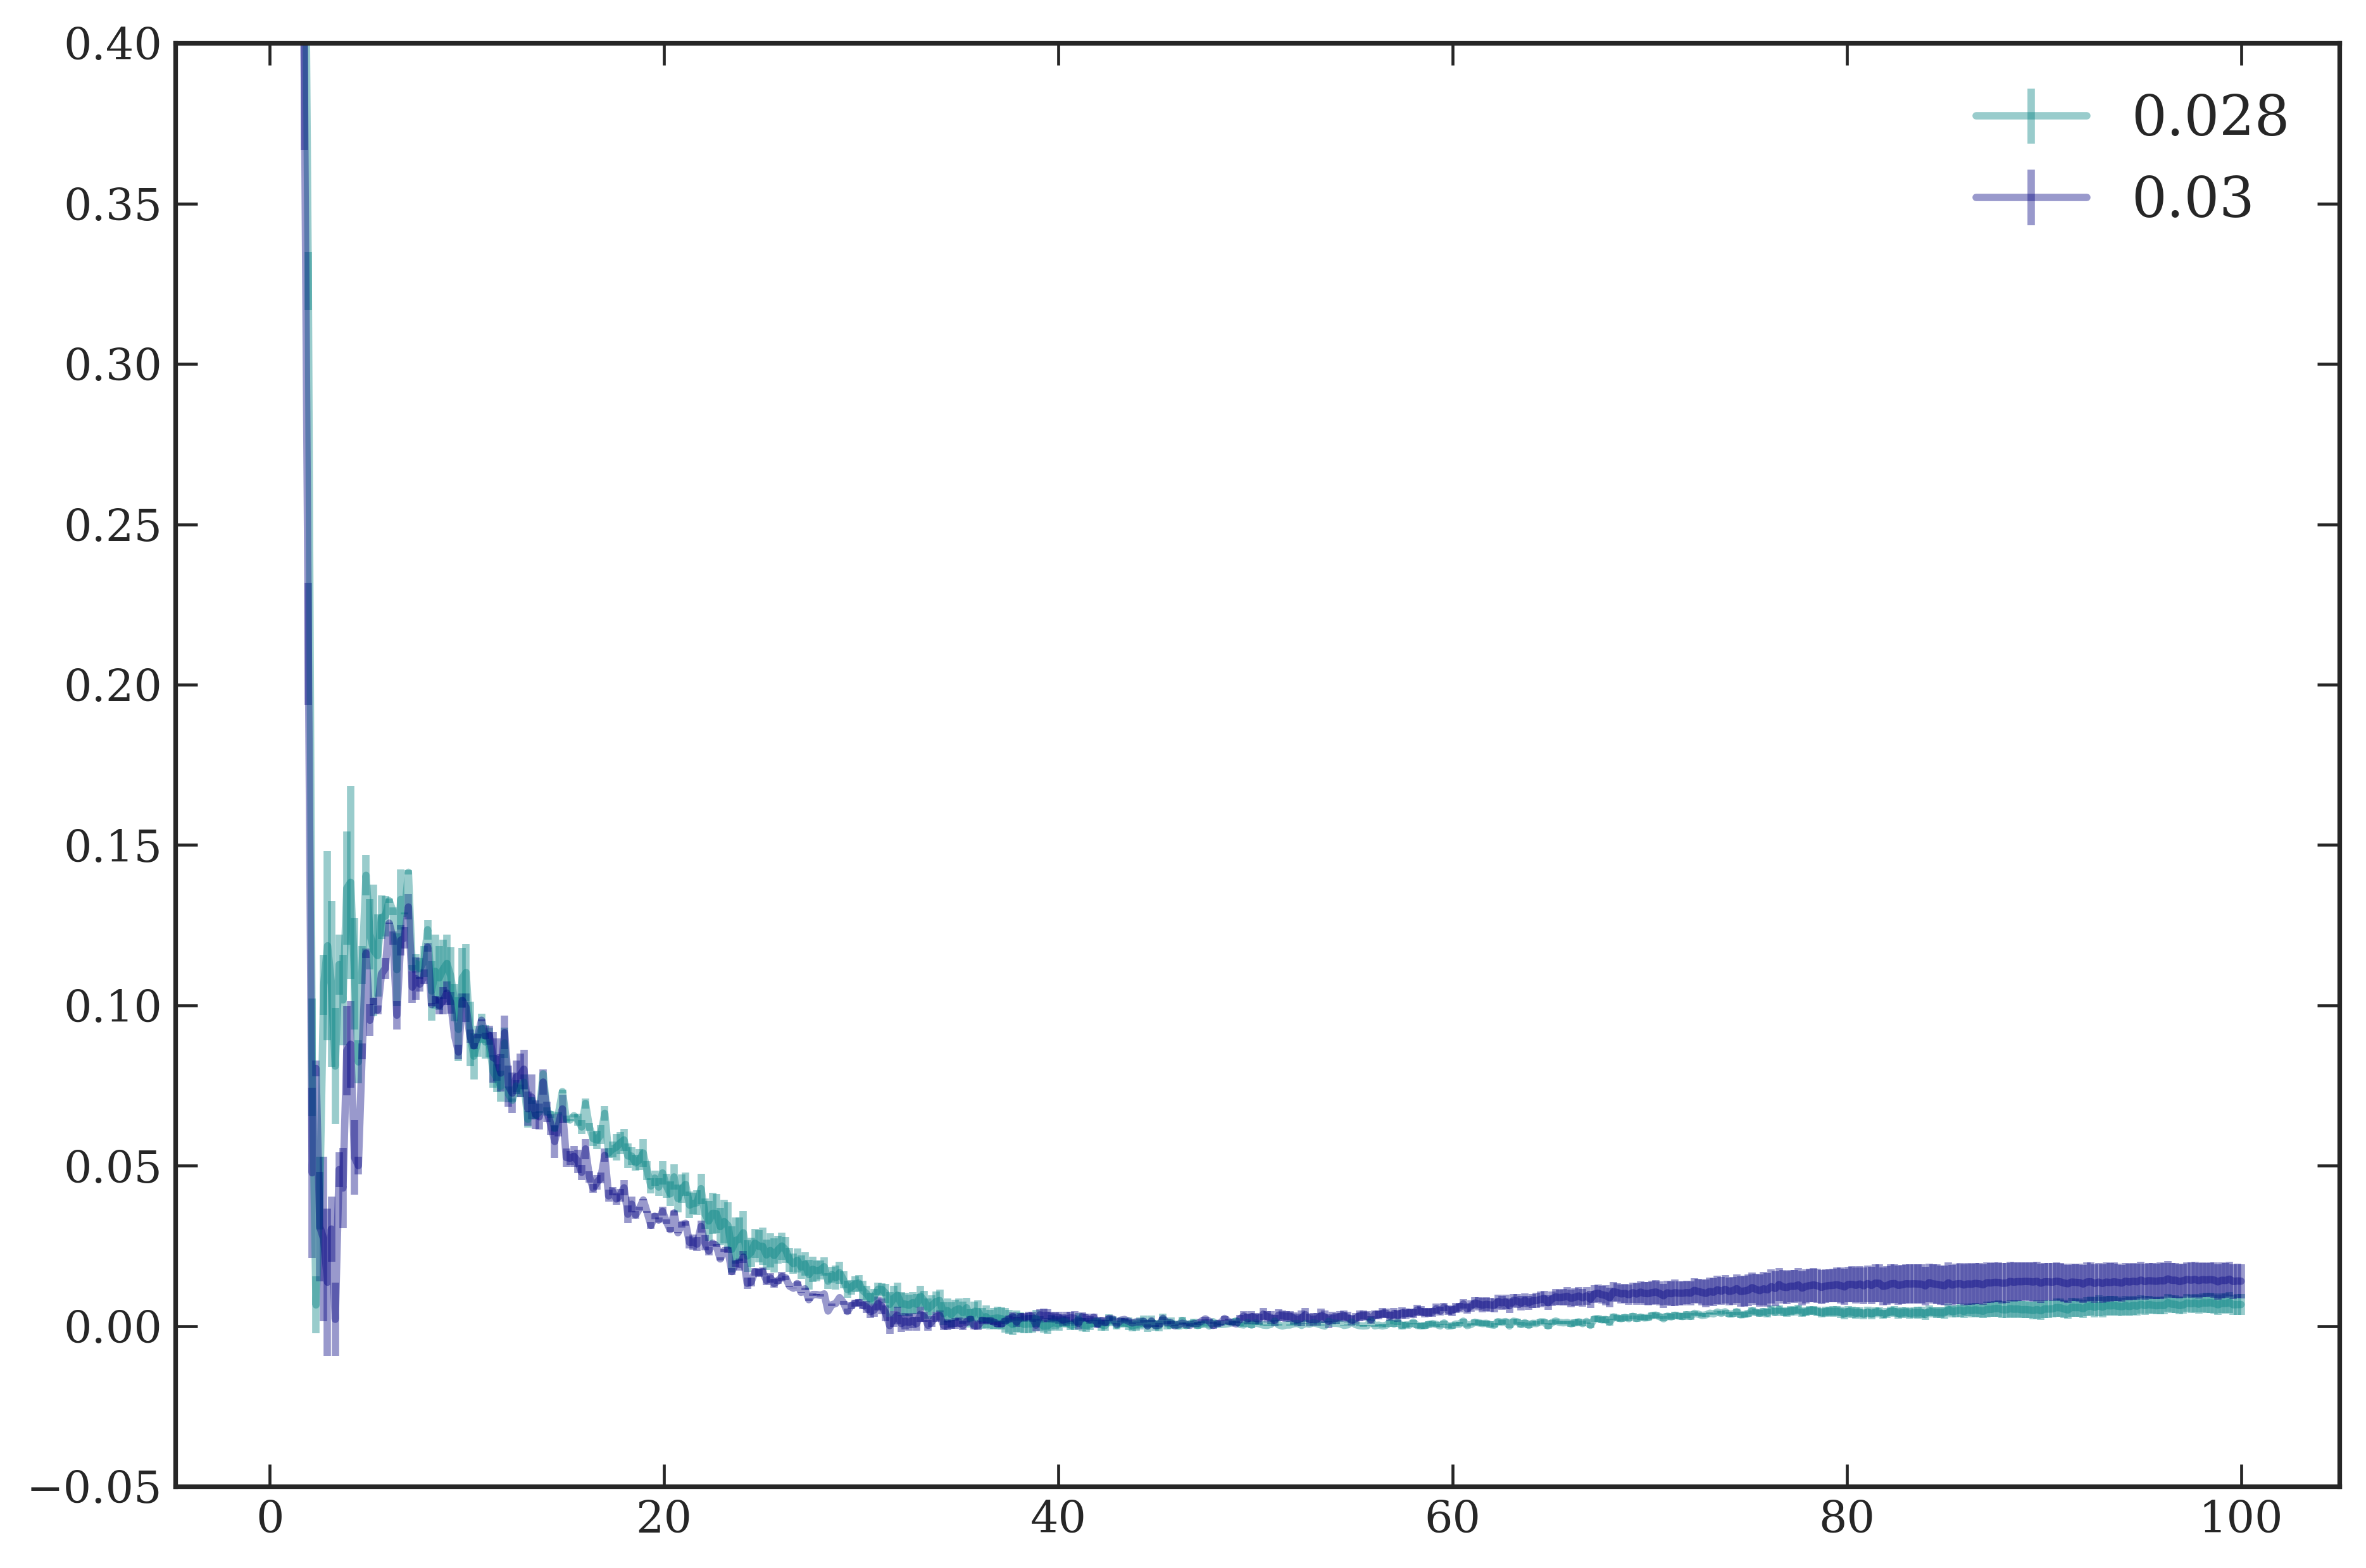

In [49]:
ax.set(ylim=[-.05, .4])
fig #knots=100 spar 1

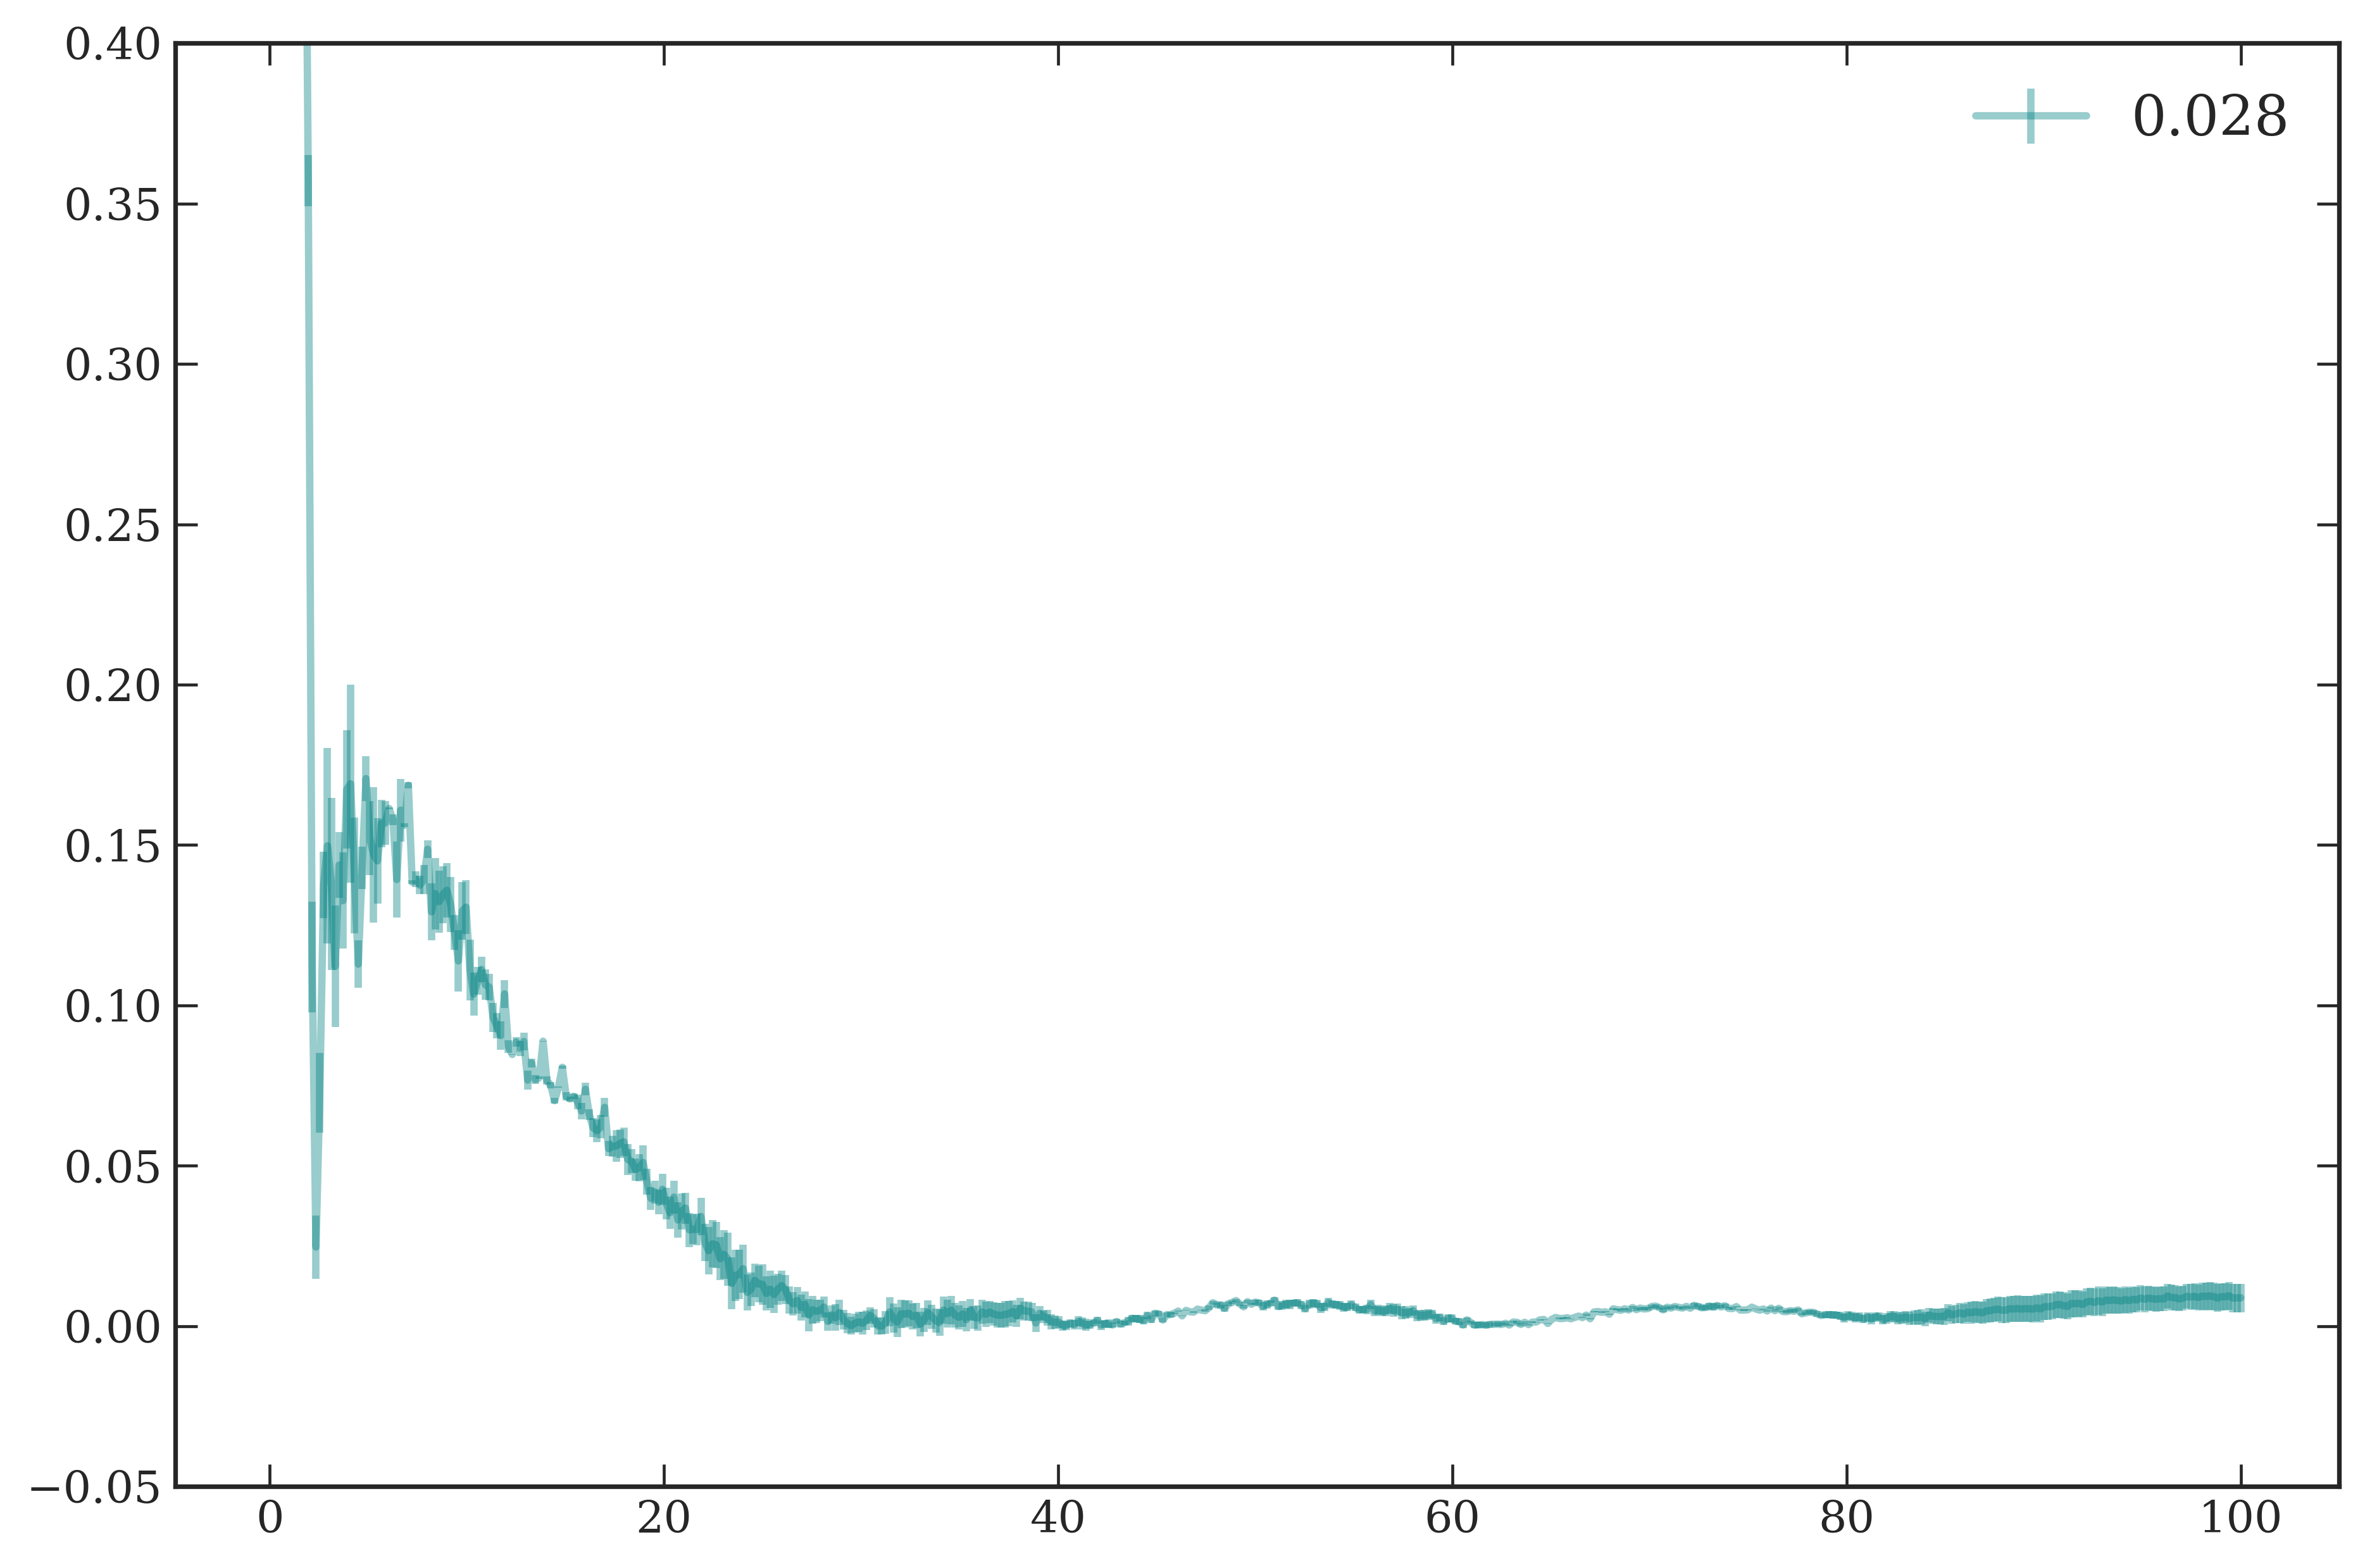

In [46]:
ax.set(ylim=[-.05, .4])
fig #knots=1

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14972\449287639.py:10: RuntimeWarning: Mean of empty slice
  ax.plot(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1), label=f'{act}', alpha=.4)


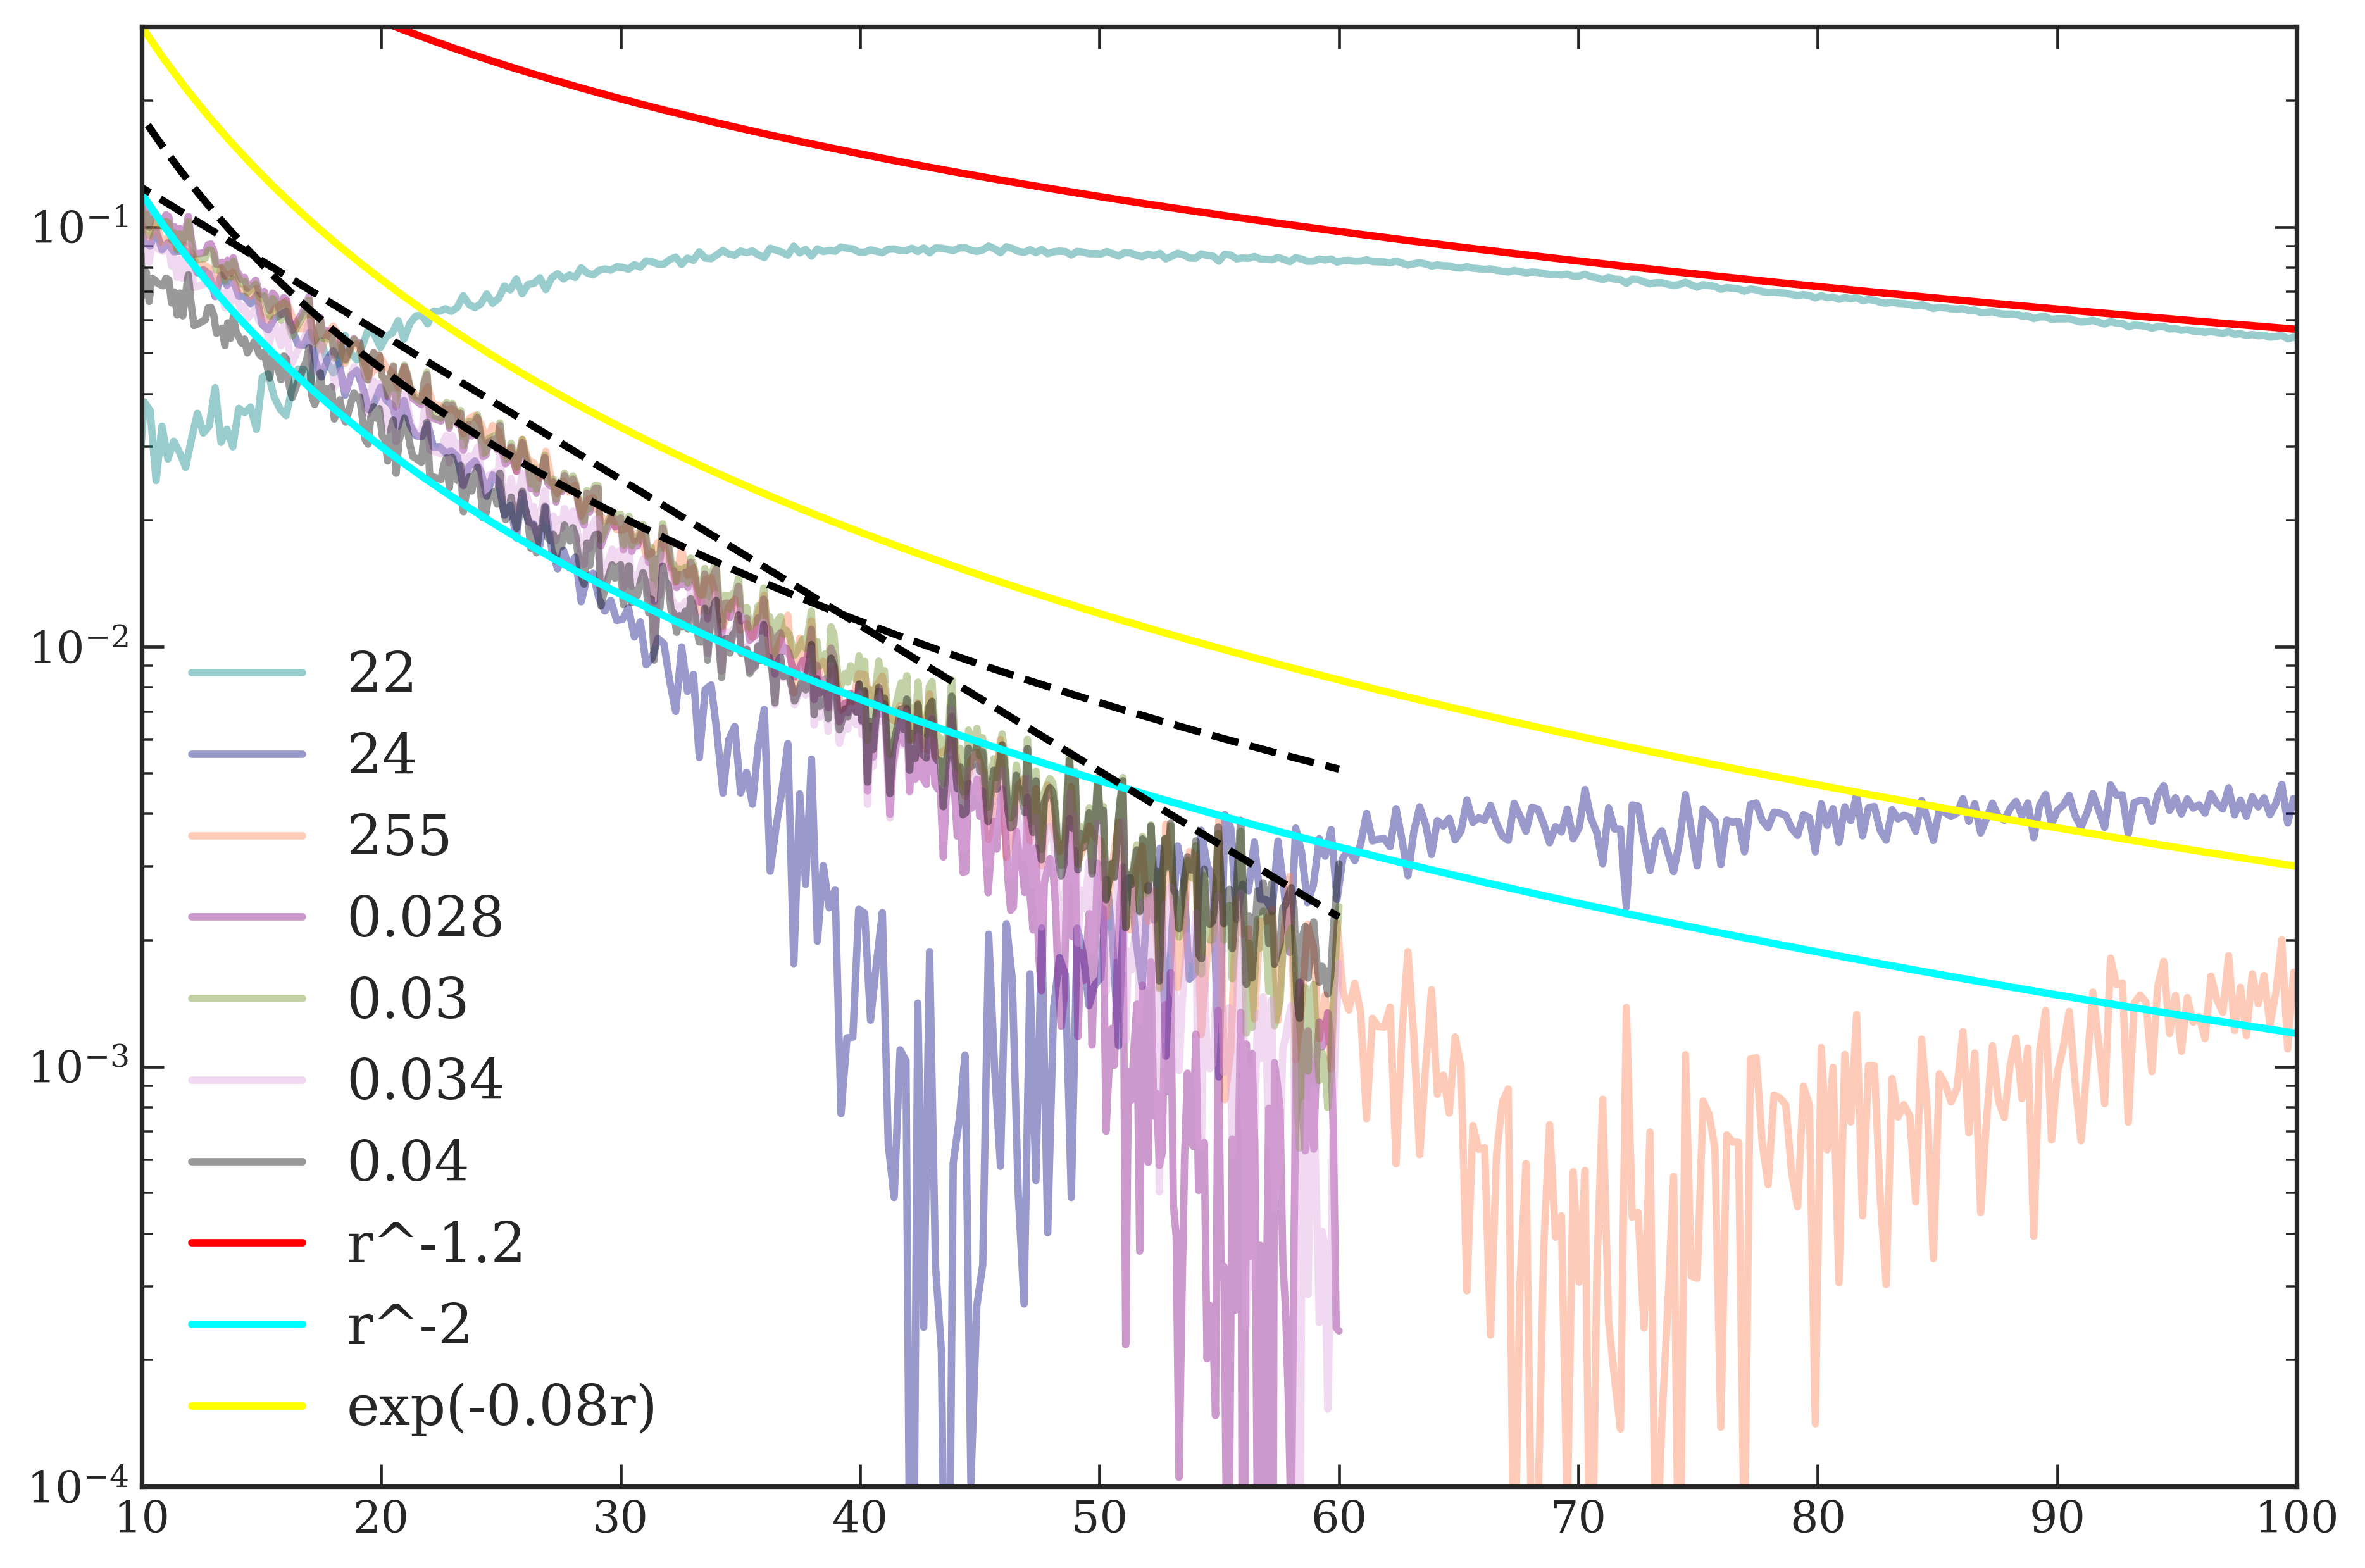

In [163]:

fig, ax = plt.subplots()
for act, dir in zip(activity_list, data_dirs):
    Nframes = 300 # 180 if act > 0.026 else 300
    rmax = 60 if act > 0.026 else 126
    act = str(act)[3:] if act < 0.026 else act
   # print(act)
    rad_arr = np.load(save_path + f'rad_arr{act}rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
    pcf_arr = np.load(save_path + f'pcf_arr{act}rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')

    ax.plot(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1), label=f'{act}', alpha=.4)
    #ax.errorbar(rad_arr, np.abs(np.nanmean(pcf_arr, axis=0) - 1),\
     #        yerr = np.nanstd(pcf_arr, axis=0)/np.sqrt(180), fmt = '.', alpha = .35,  label=f'{act}', ms=2)
ax.legend()
#ax.set(ylim=[0.,0.3], xlim=[0,70]);
ax.set(xlim=[10,100], ylim=[1e-4,3e-1])
ridx = 80
Xs = np.linspace(10,100,100)
X = np.linspace(60,100,100)
alpha=.95
Y = .8* Xs **(-2+alpha) / Xs[0] **(-2+alpha) 
Ys = 0.1* Xs **(-2) / Xs[0] **(-2)
ax.plot(Xs,.8*Y, label='r^-1.2')
ax.plot(Xs, 1.2*Ys, label='r^-2')
ax.plot(Xs, 3*Ys,)
ax.plot(rad_arr[ridx:],20* np.nanmean(pcf_arr[:,ridx]) * rad_arr[ridx:]**-2, 'k--')
ax.plot(rad_arr[ridx:],.3*np.nanmean(pcf_arr[:,ridx]) * np.exp(-0.08*rad_arr[ridx:]), 'k--')
ax.set(yscale='log')#, xscale='log')
ax.legend()

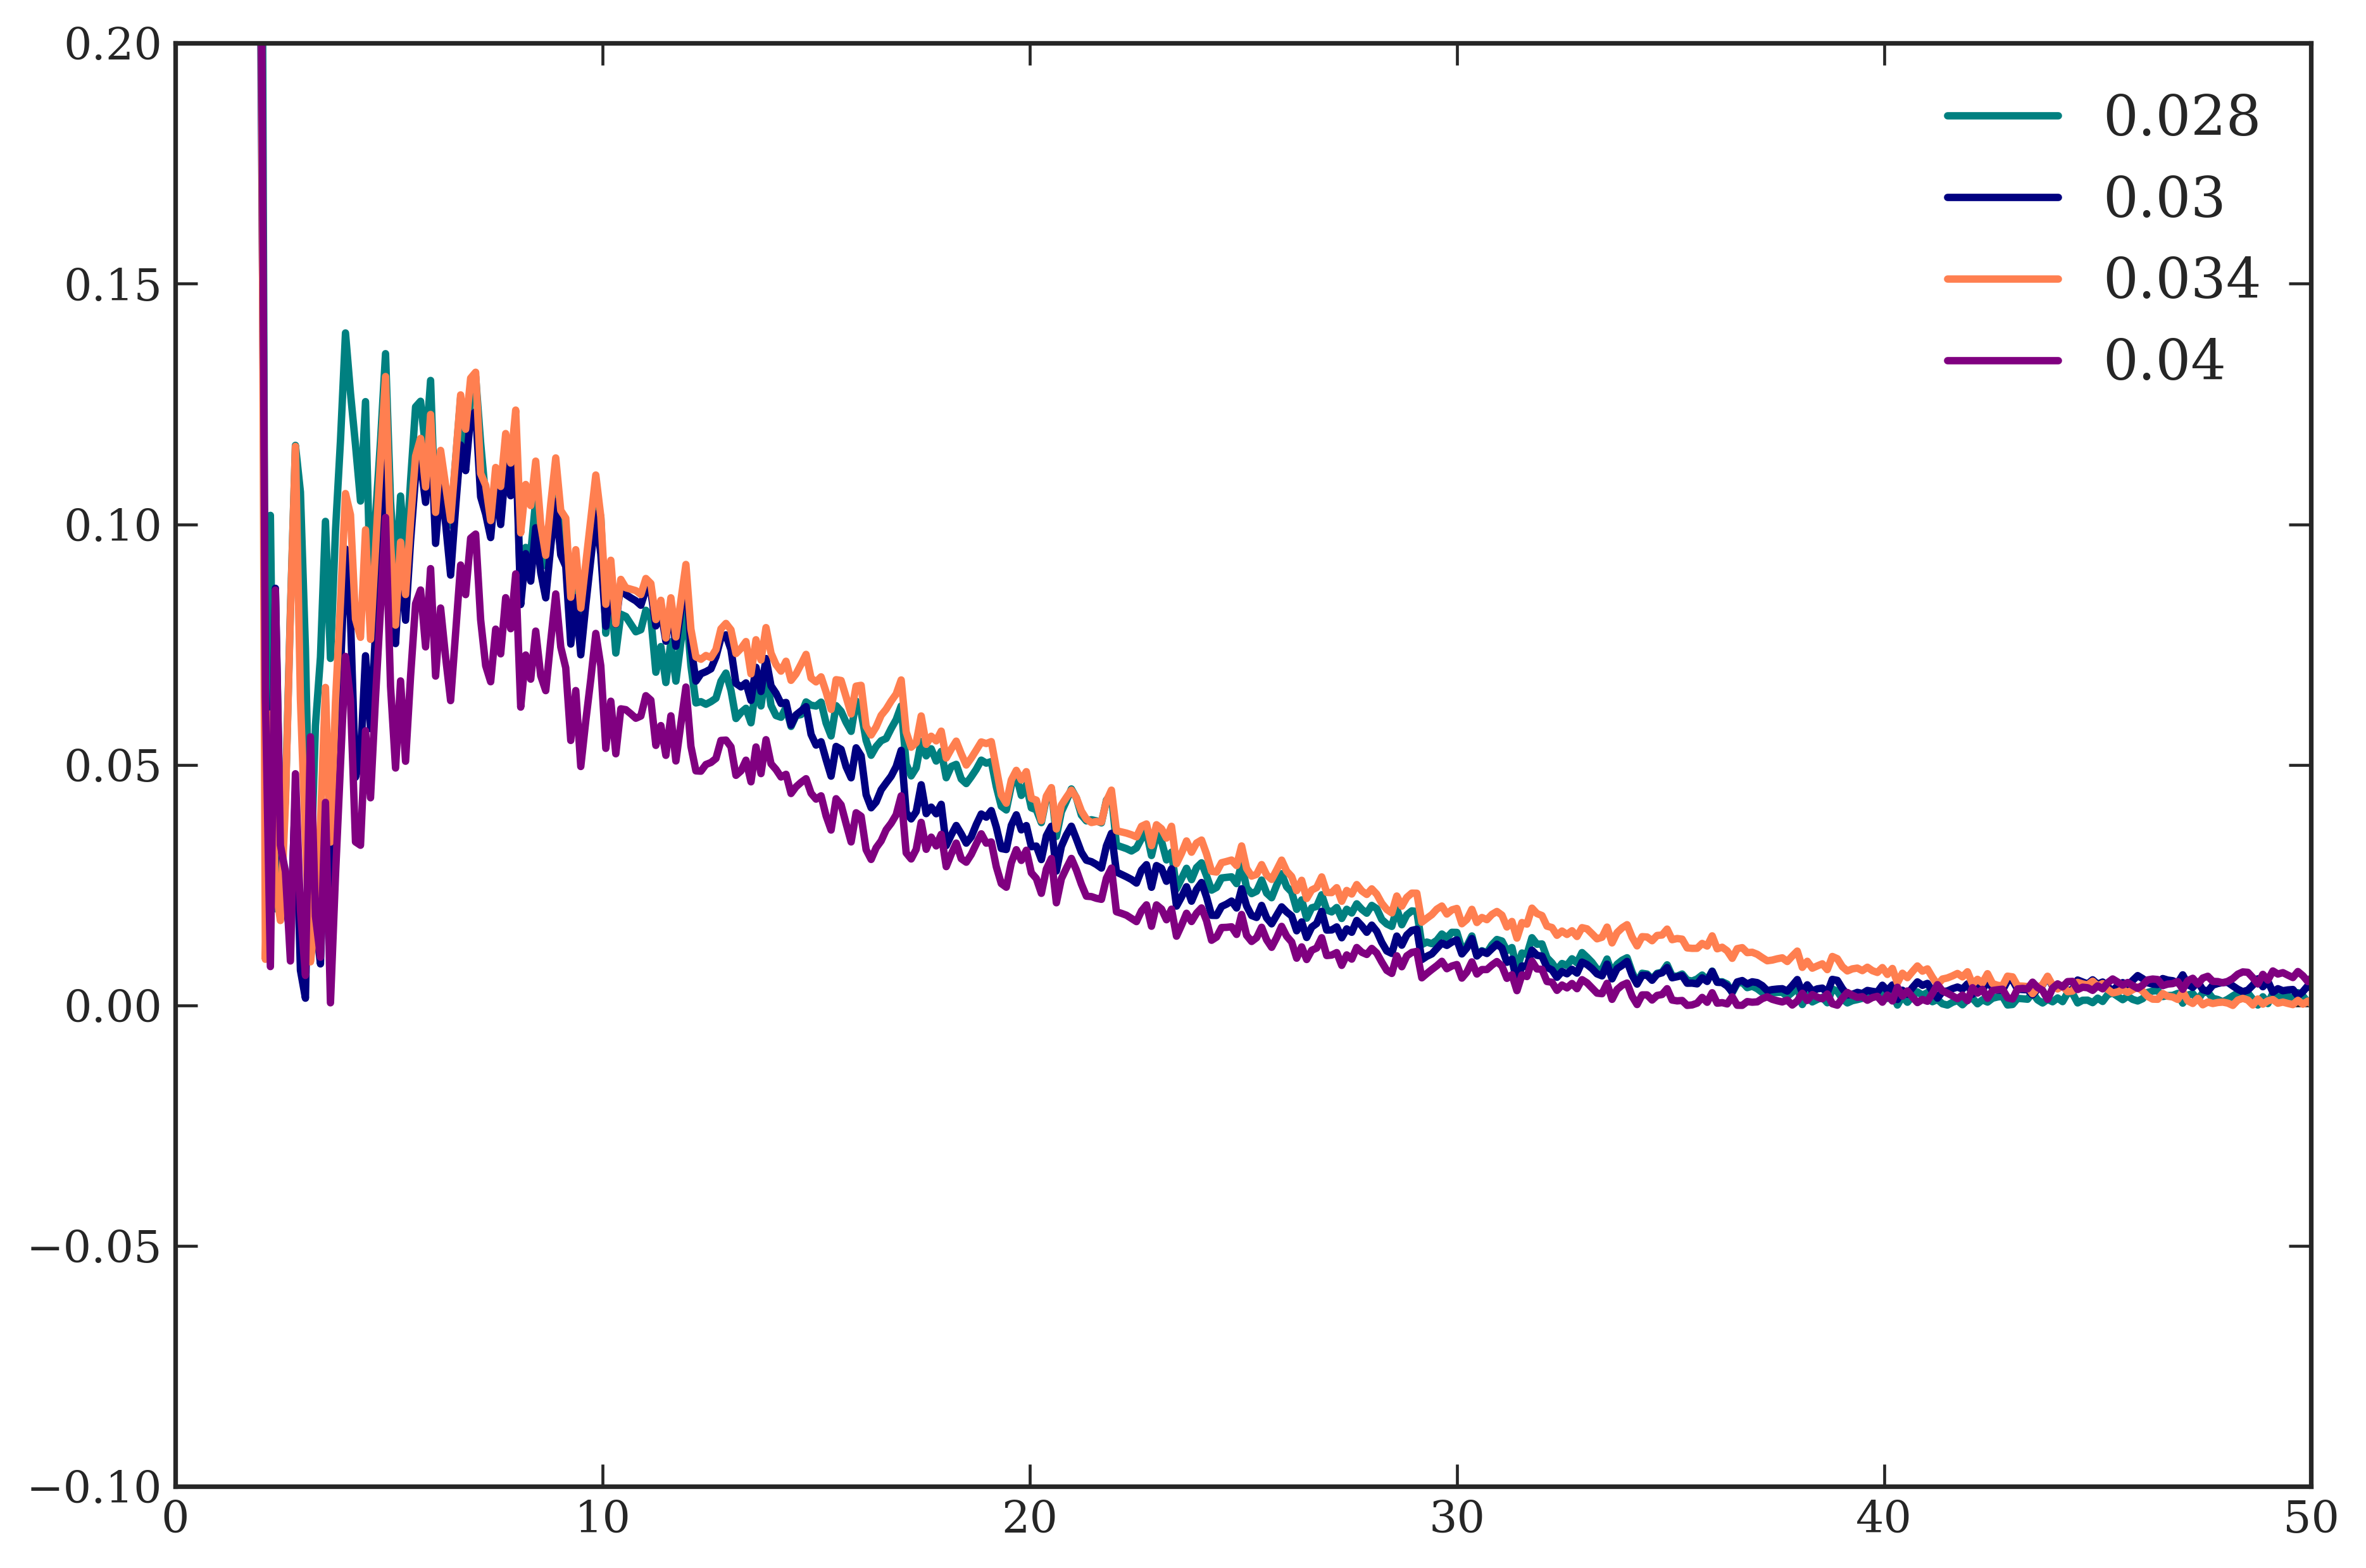

In [44]:
ax.legend()
ax.set_ylim([-.1,.2])
ax.set_xlim([0, 50])
fig

In [5]:
Nframes = 300
first_frame_idx = 0
frame_interval_vl = [1100, 1100 + Nframes]# 1400]
frame_interval_l = [0, Nframes]#300]
frame_interval_sh = [0, min(180,Nframes)] #180
#Nframes = frame_interval[1] - frame_interval[0]
LX, LY = 1024, 1024
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
rmax = ((LX-LXB)/4 - 1) / 2 

method = 'fv'
spar = .85

method_kwargs = dict(method="b", spar=spar, nknots=25)
kest_kwargs = {'rmax': rmax, 'correction': 'best', 'nlarge': 'inf', 'var.approx': False}


In [ ]:
with open(os.path.join(data_dirs[Ncl], 'defect_positions.pkl'), 'rb') as f:
    defect_list = pickle.load(f)
rad_arr, pcf_arr = get_pair_corr_from_defect_list(defect_list, window, frame_idx_interval = frame_interval_vl, method = "fv", \
                         kest_kwargs = kest_kwargs,\
                         method_kwargs = method_kwargs, save=save, save_dir=save_path,\
                              save_suffix=f'22rm{int(rmax)}_spar{spar}_nf{Nframes}')

In [31]:
# load defect_positions.pkl from data_dirs[Ncl22]
with open(os.path.join(data_dirs[Ncl22], 'defect_positions.pkl'), 'rb') as f:
    defect_list22 = pickle.load(f)
with open(os.path.join(data_dirs[Ncl24], 'defect_positions.pkl'), 'rb') as f:
    defect_list24 = pickle.load(f)
with open(os.path.join(data_dirs[Ncl255], 'defect_positions.pkl'), 'rb') as f:
    defect_list255 = pickle.load(f)

In [ ]:
if load:
     rad_arr22 = np.load(save_path + f'rad_arr22rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr22 = np.load(save_path + f'pcf_arr22rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     rad_arr24 = np.load(save_path + f'rad_arr24rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr24 = np.load(save_path + f'pcf_arr24rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     rad_arr255 = np.load(save_path + f'rad_arr255rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
     pcf_arr255 = np.load(save_path + f'pcf_arr255rm{int(rmax)}_spar{spar}_nf{Nframes}.npy')
else:
     rad_arr22, pcf_arr22 = get_pair_corr_from_defect_list(defect_list22, window, frame_idx_interval = frame_interval_vl, method = "fv", \
                         kest_kwargs = kest_kwargs,\
                         method_kwargs = method_kwargs, save=save, save_dir=save_path,\
                              save_suffix=f'22rm{int(rmax)}_spar{spar}_nf{Nframes}')
     rad_arr24, pcf_arr24 = get_pair_corr_from_defect_list(defect_list24, window, \
                         frame_idx_interval = frame_interval_l, method = "fv", \
                         kest_kwargs = kest_kwargs, method_kwargs = method_kwargs, \
                              save=save, save_dir=save_path, save_suffix=f'24rm{int(rmax)}_spar{spar}_nf{Nframes}')
     rad_arr255, pcf_arr255 = get_pair_corr_from_defect_list(defect_list255, window, \
                         frame_idx_interval = frame_interval_sh, method = "fv", \
                         kest_kwargs = kest_kwargs, method_kwargs = method_kwargs, \
                              save=save, save_dir=save_path, save_suffix=f'255rm{int(rmax)}_spar{spar}_nf{Nframes}')
pcf22_av = np.nanmean(pcf_arr22, axis = 0) - 1 
pcf24_av = np.nanmean(pcf_arr24, axis = 0) - 1
pcf22_std = np.nanstd(pcf_arr22, axis = 0)
pcf24_std = np.nanstd(pcf_arr24, axis = 0)
pcf255_av = np.nanmean(pcf_arr255, axis = 0) - 1
pcf255_std = np.nanstd(pcf_arr255, axis = 0)


In [ ]:
Nframes = 200
pcf22_av = np.nanmean(pcf_arr22[:Nframes], axis = 0) - 1 
pcf24_av = np.nanmean(pcf_arr24[:Nframes], axis = 0) - 1
pcf22_std = np.nanstd(pcf_arr22[:Nframes], axis = 0) / np.sqrt(pcf_arr22[-Nframes:].shape[0])
pcf24_std = np.nanstd(pcf_arr24[:Nframes], axis = 0) / np.sqrt(pcf_arr24[-Nframes:].shape[0])
pcf255_av = np.nanmean(pcf_arr255[:min(Nframes,180)], axis = 0) - 1
pcf255_std = np.nanstd(pcf_arr255[:min(Nframes,180)], axis = 0) / np.sqrt(pcf_arr255.shape[0])

In [ ]:
x0 = 10
x0_22 = 20
fit_func = lambda r, A, B: A*np.exp(-B*(r-x0))
fit_func22 = lambda r, A, B: A*np.exp(-B*(r-x0))
param_guess = [-0.15, 2]
params_guess22 = [0.15, 1.2]
point_bounds = [50,250]
point_bounds24 = [50, 180]
point_bounds22 = [300, 400]
x255 = rad_arr255[point_bounds[0]:point_bounds[1]]
y255 = pcf255_av[point_bounds[0]:point_bounds[1]]
yerr255 = pcf255_std[point_bounds[0]:point_bounds[1]]
x24 = rad_arr24[point_bounds24[0]:point_bounds24[1]]
y24 = pcf24_av[point_bounds24[0]:point_bounds24[1]]
yerr24 = pcf24_std[point_bounds24[0]:point_bounds24[1]]
x22 = rad_arr22[point_bounds22[0]:point_bounds22[1]]
y22 = pcf22_av[point_bounds22[0]:point_bounds22[1]]
yerr22 = pcf22_std[point_bounds22[0]:point_bounds22[1]]

fit255 = do_chi2_fit(fit_func, x255, y255, yerr255, param_guess, verbose = False)
fit24 = do_chi2_fit(fit_func, x24, y24, yerr24, param_guess, verbose = False)
fit22 = do_chi2_fit(fit_func, x22, y22, yerr22, param_guess, verbose = False)
fit255.values[:], fit255.errors[:], fit22.values[:]

(0.0, 120.0)

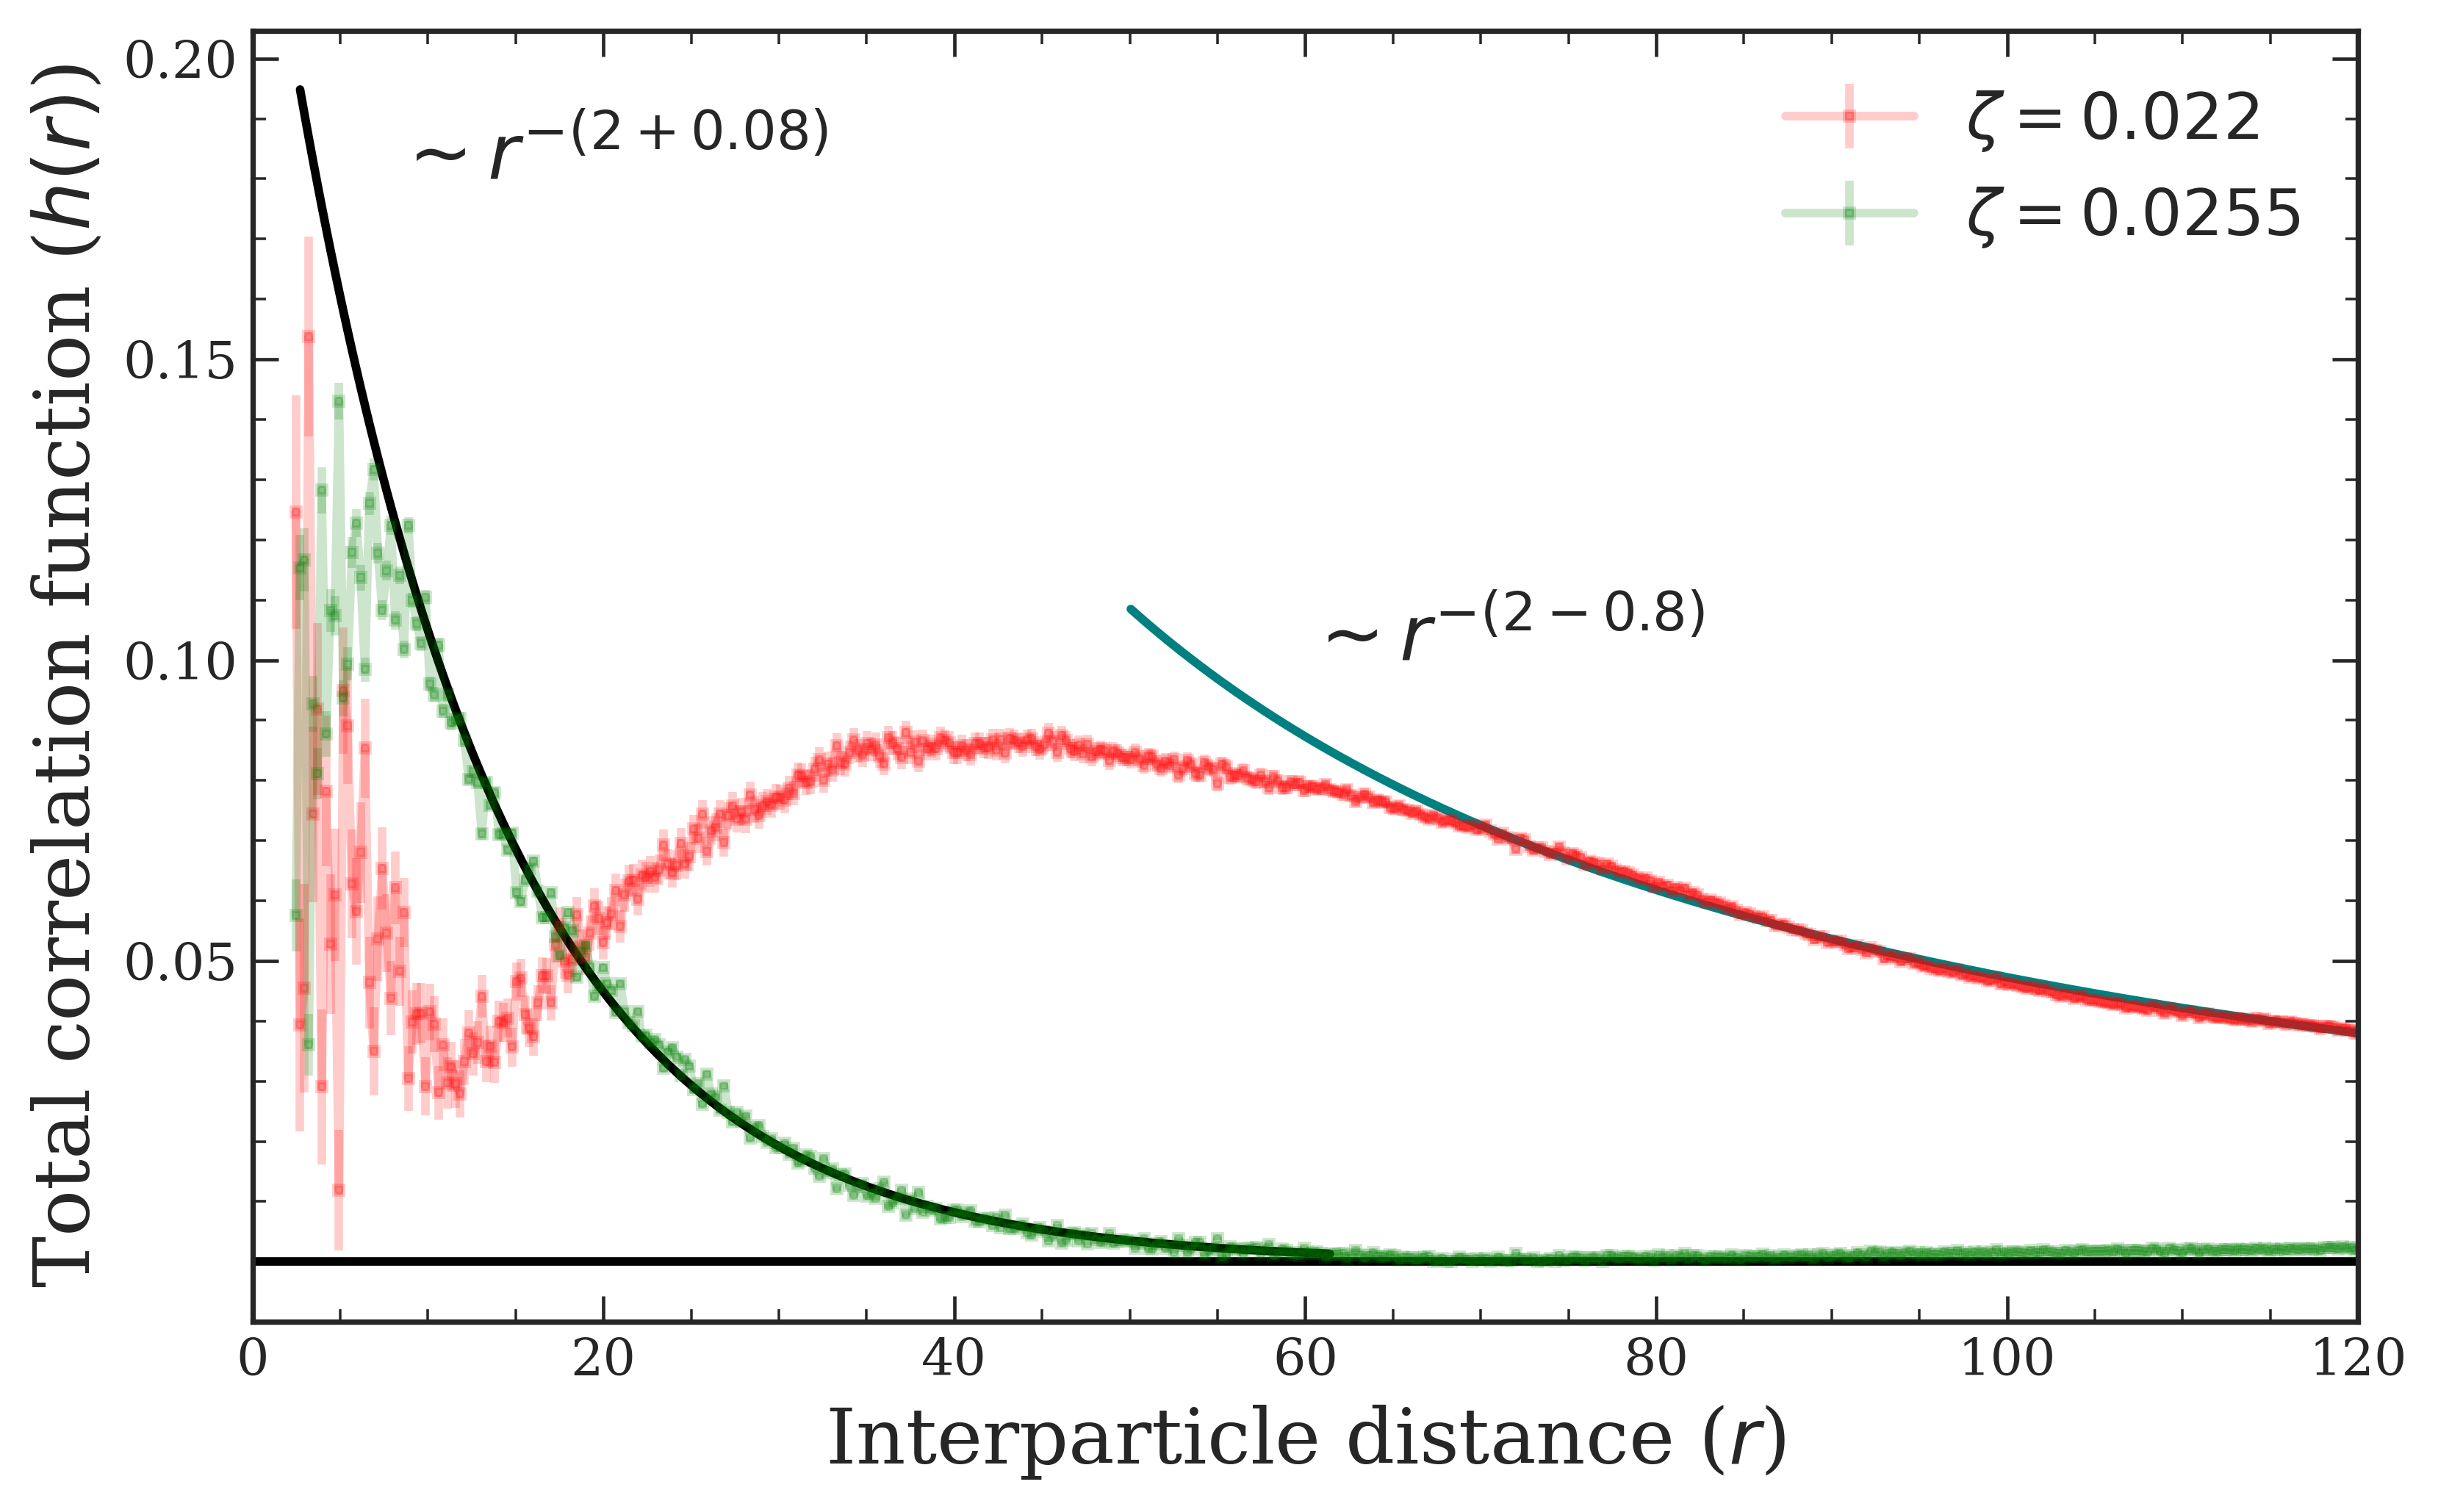

In [11]:
min_idx22 = 10
min_idx24 = 30
min_idx255 = 10

argmax22 = np.argmin(np.abs(rad_arr22-50))  

argmax24 = np.argmin(np.abs(rad_arr24-15)) # np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
argmax255 = np.argmax(np.abs(pcf255_av[min_idx255:])) + min_idx255
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)
fig, ax = plt.subplots(figsize=(8,5 ))

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = r'$\zeta = 0.022$', alpha = .2, color = 'red', markersize = 2)
#ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
 #            fmt = 's-', label = 'Ncl24', alpha = .2, color = 'blue',  markersize = 2)
ax.errorbar(rad_arr255[min_idx255:], np.abs(pcf255_av[min_idx255:]), yerr = pcf255_std[min_idx255:],\
             fmt = 's-', label = r'$\zeta = 0.0255$', alpha = .2, color = 'green',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='-', colors='k')

yticks = np.linspace(0.05, 0.2,4)
ax.set(yticks=yticks, yticklabels=[f'{y:.2f}' for y in yticks])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

alpha22 = -.8
alpha24 = - -.3 #.05
argmax24 += -50
#ax.plot(rad_arr24[argmax24:], 1*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
  #       '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=1)
ax.plot(rad_arr22[argmax22:], 1.3*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', ms=3, alpha=1)
#ax.plot(x255, np.abs(fit_func(x255, *fit255.values)), '-', label = r'$\sim r^{-(2+0.08)}$', ms=3, alpha=1, lw=2, color='black')
ax.plot(rad_arr24[argmax24:250], np.abs(fit_func(rad_arr24[argmax24:250], *fit255.values)), '-', ms=3, alpha=1, lw=2, color='black')
#ax.plot(x24, np.abs(fit_func(x24, *fit24.values)), '-', label = r'$\sim e^{-2(r-10)}$', ms=3, alpha=1, lw=2, color='black')
#ax.text(0.5, 0.5, f'$\zeta = 0.022$: $A = {fit22.values[0]:.2f}$, $B = {fit22.values[1]:.2f}$', transform=ax.transAxes)
ax.text(8,.18, r'$\sim r^{-(2 + 0.08)}$', fontsize=18) #, transform=ax.transAxes)
ax.text(60,.1, r'$\sim r^{-(2 - 0.8)}$', fontsize=18) #, transform=ax.transAxes)
ax.legend()
#ax.set_ylim(-.05,0.15)

ax.set_ylabel(r'Total correlation function ($h(r)$)')
ax.set_xlabel(r'Interparticle distance ($r$)')
ax.set_xlim(0, 120);

In [15]:
def produce_scaling(X, scaling_exp, Y0, x_bounds,):
    x = X[x_bounds[0]:x_bounds[1]]

    return x, Y0 * x**scaling_exp / x[0]**scaling_exp

In [14]:
N = 2

def_arr, var_counts, dens_fluc, av_counts, av_def = ad.get_arrays_av(Ndataset=N, return_av_counts=True, use_merged=True)
act_list = ad.act_list[0]
av_counts_av = np.mean(av_counts, axis=0)
var_counts_av = np.mean(var_counts, axis=0)
dens_fluc_av = np.mean(dens_fluc, axis=0)
windows = ad.window_sizes[0]

av_dens = av_counts_av / (np.pi * (windows**2)[:,None,None])
var_counts_norm = var_counts_av / (np.pi * (windows**2)[:,None,None])

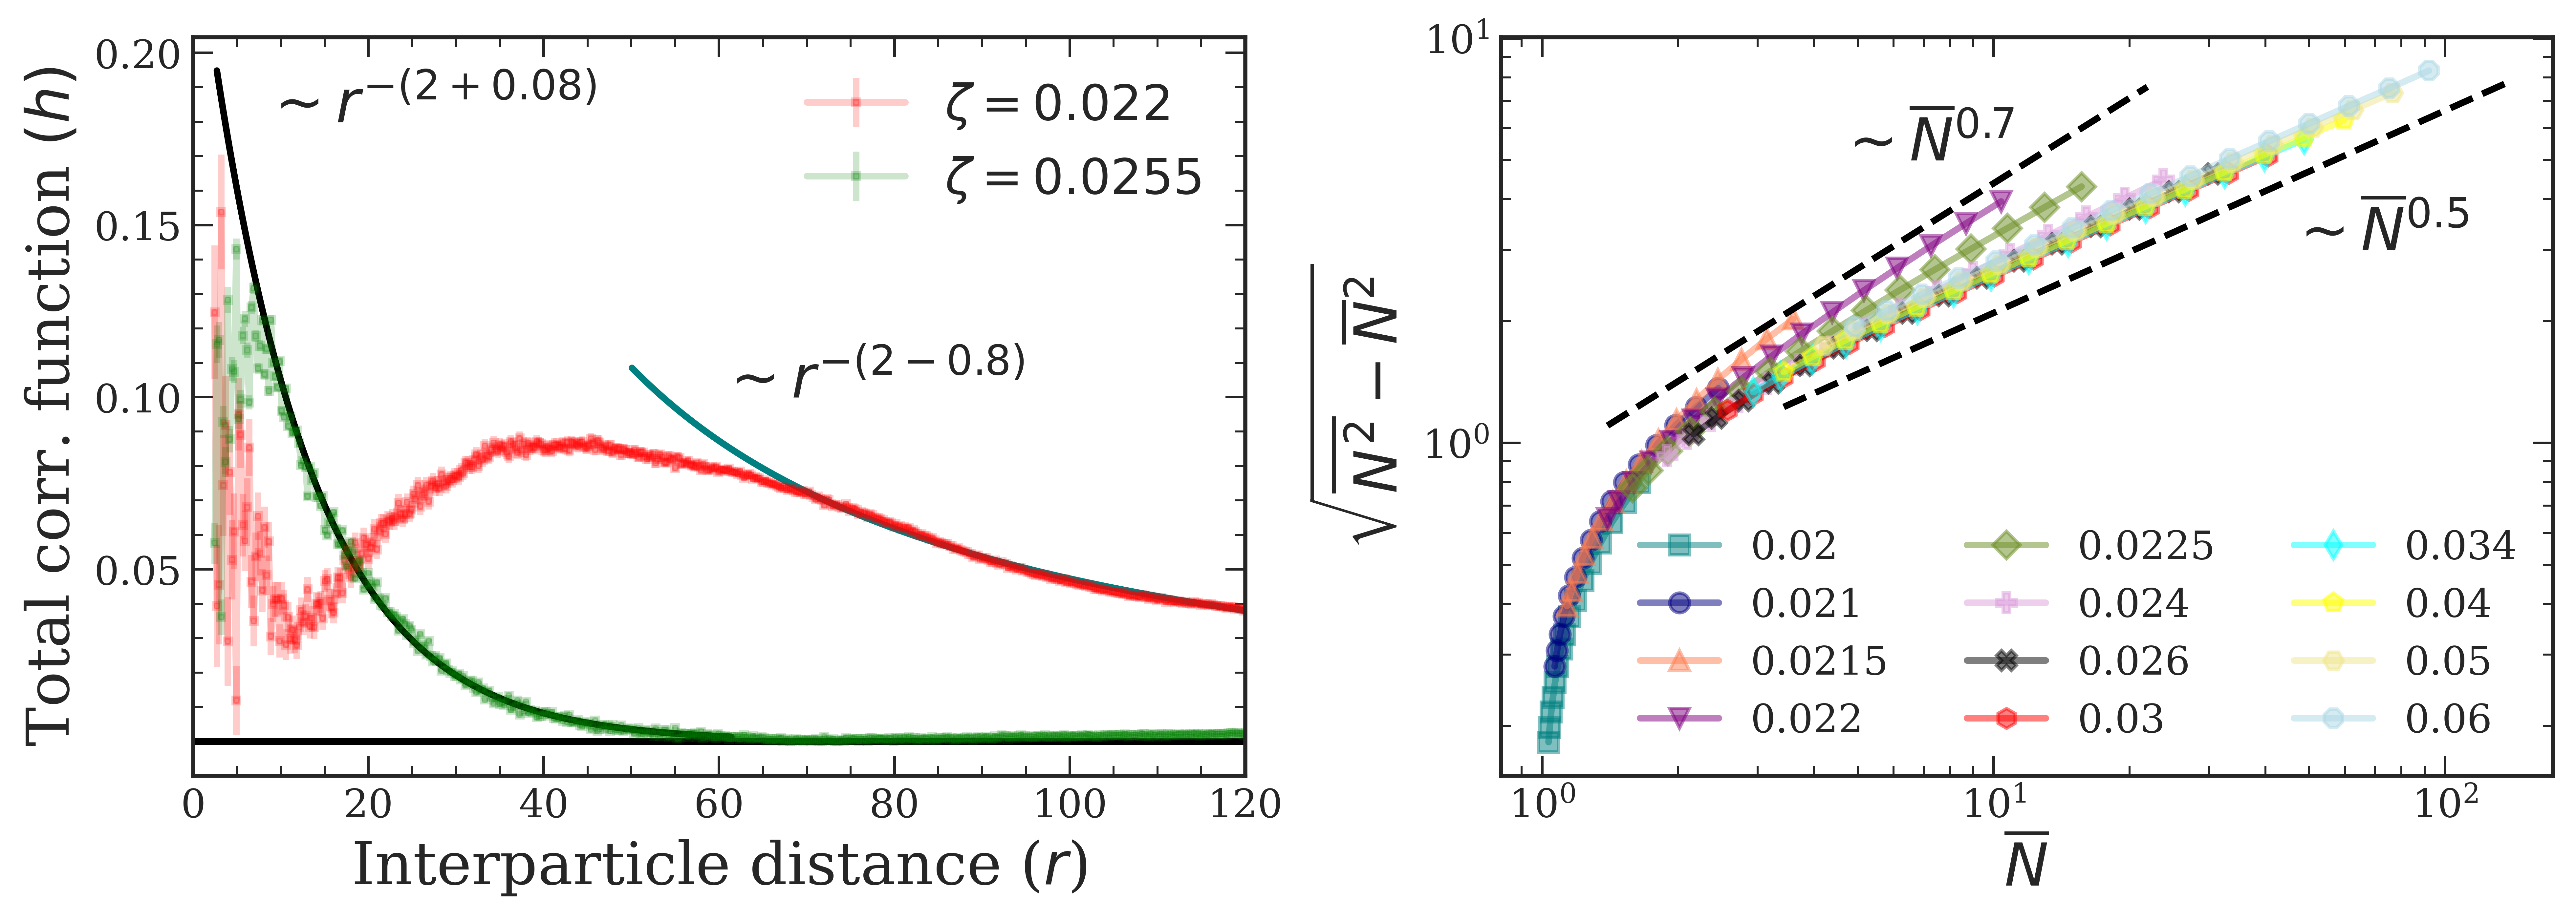

In [41]:

fig, ax0 = plt.subplots(nrows = 1, ncols = 2, figsize=(11,4)) 
marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
ax0 = ax0.flatten()
ax = ax0[0]
axx = ax0[1]

min_idx22 = 10
min_idx24 = 30
min_idx255 = 10

argmax22 = np.argmin(np.abs(rad_arr22-50))  

argmax24 = np.argmin(np.abs(rad_arr24-15)) # np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
argmax255 = np.argmax(np.abs(pcf255_av[min_idx255:])) + min_idx255
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = r'$\zeta = 0.022$', alpha = .2, color = 'red', markersize = 2)
#ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
 #            fmt = 's-', label = 'Ncl24', alpha = .2, color = 'blue',  markersize = 2)
ax.errorbar(rad_arr255[min_idx255:], np.abs(pcf255_av[min_idx255:]), yerr = pcf255_std[min_idx255:],\
             fmt = 's-', label = r'$\zeta = 0.0255$', alpha = .2, color = 'green',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='-', colors='k')

yticks = np.linspace(0.05, 0.2,4)
ax.set(yticks=yticks, yticklabels=[f'{y:.2f}' for y in yticks])
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

alpha22 = -.8
alpha24 = - -.3 #.05
argmax24 += -50
#ax.plot(rad_arr24[argmax24:], 1*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
  #       '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=1)
ax.plot(rad_arr22[argmax22:], 1.3*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', ms=3, alpha=1, lw=2)
#ax.plot(x255, np.abs(fit_func(x255, *fit255.values)), '-', label = r'$\sim r^{-(2+0.08)}$', ms=3, alpha=1, lw=2, color='black')
ax.plot(rad_arr24[argmax24:250], np.abs(fit_func(rad_arr24[argmax24:250], *fit255.values)), '-', ms=3, alpha=1, lw=2, color='black')
#ax.plot(x24, np.abs(fit_func(x24, *fit24.values)), '-', label = r'$\sim e^{-2(r-10)}$', ms=3, alpha=1, lw=2, color='black')
#ax.text(0.5, 0.5, f'$\zeta = 0.022$: $A = {fit22.values[0]:.2f}$, $B = {fit22.values[1]:.2f}$', transform=ax.transAxes)
ax.text(8,.18, r'$\sim r^{-(2 + 0.08)}$', fontsize=18) #, transform=ax.transAxes)
ax.text(60,.1, r'$\sim r^{-(2 - 0.8)}$', fontsize=18) #, transform=ax.transAxes)
ax.legend()
#ax.set_ylim(-.05,0.15)

ax.set_ylabel(r'Total corr. function $(h)$')
ax.set_xlabel(r'Interparticle distance ($r$)')
ax.set_xlim(0, 120);



window_idx_bounds = [10,-4]
marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']
act_list = ad.act_list[0]

acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.0225, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
if ad.LX[0] == 2048:
    acts_to_plot = [0.02, 0.021, 0.0215, 0.022, 0.024, 0.026, 0.03, 0.034, 0.04, 0.05, 0.06]
for i, act in enumerate(acts_to_plot):
    idx = act_list.index(act)
    axx.plot(av_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0], np.sqrt(var_counts_av[window_idx_bounds[0]:window_idx_bounds[1],idx,0]),\
             label=f'{act}', marker=marker_shape[i], alpha=.5)


idx22 = act_list.index(0.022)
idx40 = act_list.index(0.040)
scaling22 = (1+0.8/2)/2
window_idx_bounds = [10,None]


#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.69, label=r'$\sim x^{0.7}$', color='black', lw=1.5, linestyle='--')
#ax.plot(av_counts_av[:,idx,0], 0.8*av_counts_av[:,idx,0]**0.5,label=r'$\sim x^{0.5}$', color='black', lw=1.5, linestyle='-')


x22, y22 = produce_scaling(av_counts_av[:, idx22, 0], scaling22, np.sqrt(var_counts_av[window_idx_bounds[0],idx22,0]), window_idx_bounds,)
x40, y40 = produce_scaling(av_counts_av[:, idx40, 0], .5, np.sqrt(var_counts_av[window_idx_bounds[0],idx40,0]), window_idx_bounds,)
axx.plot(x22, 1.7*y22, color='black', linestyle='--')
axx.plot(x40, y40*0.82,  color='black', linestyle='--')
axx.text(45,3, r'$\sim \overline{N}^{0.5}$', fontsize=18)
axx.text(4.5, 5, r'$\sim \overline{N}^{0.7}$', fontsize=18)

axx.set_xlabel(r'$\overline{N}$')
axx.set_ylabel(r'$\sqrt{\overline{N^2} - \overline{N}^2}$')
#ax.set_ylim(.5,8)
#ax.set_xlim(1,100)
axx.legend(ncols=3,fontsize=12)
axx.set_xscale('log')
axx.set_yscale('log')




fig.tight_layout()
fig.dpi = 720
#fig.savefig('data/nematic_analysis_all/susceptibility.eps', dpi = 720, pad_inches = .5)

In [ ]:
min_idx22 = 10
min_idx24 = 30
min_idx255 = 10

argmax22 = np.argmin(np.abs(rad_arr22-50))  

argmax24 = np.argmin(np.abs(rad_arr24-15)) # np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
argmax255 = np.argmax(np.abs(pcf255_av[min_idx255:])) + min_idx255
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)
fig, ax = plt.subplots()

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = r'$\zeta = 0.022$', alpha = .2, color = 'red', markersize = 2)
#ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
 #            fmt = 's-', label = 'Ncl24', alpha = .2, color = 'blue',  markersize = 2)
ax.errorbar(rad_arr255[min_idx255:], np.abs(pcf255_av[min_idx255:]), yerr = pcf255_std[min_idx255:],\
             fmt = 's-', label = r'$\zeta = 0.0255$', alpha = .2, color = 'green',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='dashed', colors='k')

alpha22 = -.87
alpha24 = -.05
argmax24 += -16
ax.plot(rad_arr24[argmax24:], 2.15*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
         '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=1)
ax.plot(rad_arr22[argmax22:], 2.03*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', label = r'$\sim r^{-1.2}$', ms=3, alpha=1)
ax.legend()
ax.set_ylim(-.05,0.15)
ax.set_ylabel(r'Total correlation function ($h(r)$)')
ax.set_xlabel(r'Interparticle distance ($r$)')
#ax.set_xlim(0, 100)

In [ ]:
min_idx22 = 10
min_idx24 = 10
argmax22 = np.argmax(pcf22_av[min_idx22:]) + min_idx22+5
argmax24 = np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)
fig, ax = plt.subplots()

#ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')

ax.errorbar(rad_arr22[min_idx22:], pcf22_av[min_idx22:], yerr = pcf22_std[min_idx22:], fmt = 's-', \
            label = 'Ncl22', alpha = .3, color = 'red', markersize = 2)
ax.errorbar(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), yerr = pcf24_std[min_idx24:],\
             fmt = 's-', label = 'Ncl24', alpha = .3, color = 'blue',  markersize = 2)
ax.hlines(0, 0, 120, linestyles='dashed', colors='k')

alpha22 = -.8
alpha24 = -.1
ax.plot(rad_arr24[argmax24:], 2.5*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
         '-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=.5)
ax.plot(rad_arr22[argmax22:], 2.4*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '-', label = r'$\sim r^{-1.2}$', ms=3, alpha=.5)
ax.legend()

In [ ]:
min_idx22 = 10
min_idx24 = 10
argmax22 = np.argmax(pcf22_av[min_idx22:]) + min_idx22+5
argmax24 = np.argmax(np.abs(pcf24_av[min_idx24:])) + min_idx24
fig, ax = plot_pair_corr_function(rad_arr = rad_arr22[min_idx22:], pcf_arr = pcf22_av[min_idx22:], plot_norm = False)
ax.plot(rad_arr24[min_idx24:], np.abs(pcf24_av[min_idx24:]), label = 'abs Ncl24')
ax.hlines(0, 0, 120, linestyles='dashed', colors='k')

alpha22 = -1
alpha24 = -.1
ax.plot(rad_arr22[argmax24:], 1.8*np.abs(pcf24_av[argmax24]) * rad_arr24[argmax24:]**(-2-alpha24) / rad_arr24[argmax24]**(-2-alpha24),\
         '.-', label = r'$\sim r^{-1.9}$', markersize=3,alpha=.5)
ax.plot(rad_arr22[argmax22:], 1.5*pcf22_av[argmax22] * rad_arr22[argmax22:]**(-2-alpha22) / rad_arr22[argmax22]**(-2-alpha22),\
         '.-', label = r'$\sim r^{-1.2}$', ms=3, alpha=.5)
ax.legend()

In [6]:
path

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

In [12]:
data_dirs = [os.path.join(path, dir_name) for dir_name in os.listdir(path)]
paths = [data_dirs[-6], data_dirs[-5], data_dirs[-4],]
act_list = [0.021, 0.022, 0.028,]
data_dirs, paths

(['C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\compressed_data',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a22n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a24n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a255n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a28n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a30n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a34n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\na1024_a40n0_cl',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\ns1024_06',
  'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Spec

In [21]:
data_dirs[12]

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\ns512a28n0'

In [ ]:
import glob
for dir in data_dirs:
    print(dir)
    files = glob.glob(dir + '/frame*')
    print(len(files))   

In [24]:
N = 12
ar = mp.archive.loadarchive(data_dirs[N])
frame_interval = [0, len(os.listdir(data_dirs[N]))-2]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = 512, 512 # ar._read_frame(0).LX, ar._read_frame(0).LY
#defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
knots = int(rmax / 2)

print(rmax, knots)
method = 'fv'
method_kwargs = dict(method="b", spar=.85, nknots=knots)
kest_kwargs = {'rmax': rmax, 'correction': 'good', 'nlarge': 3000, 'var.approx': False}


124.5 62


In [25]:
rad_arr, pcf_arr = get_pair_corr_function(ar, data_dirs[N], window, frame_interval = frame_interval, method = "fv", \
                            kest_kwargs = kest_kwargs,\
                                method_kwargs = method_kwargs)
pcf_av = np.nanmean(pcf_arr, axis = 0) - 1 

R[write to console]: Error in (function (x, y = NULL, w = NULL, df, spar = NULL, lambda = NULL,  : 
  'tol' must be strictly positive and finite

R[write to console]: In addition: 
R[write to console]: There were 19 warnings (use warnings() to see them)
R[write to console]: 



RRuntimeError: Error in (function (x, y = NULL, w = NULL, df, spar = NULL, lambda = NULL,  : 
  'tol' must be strictly positive and finite


In [44]:
pcf_av = np.nanmean(pcf_arr, axis = 0) - 1 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_16580\261489916.py:1: RuntimeWarning: Mean of empty slice
  pcf_av = np.nanmean(pcf_arr, axis = 0) - 1


In [ ]:
for pcf_vals in range(pcf_arr.shape[0]):
    fig, ax = plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[pcf_vals] - 1, plot_norm = False)
#fig, ax = plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_av-1, plot_norm = False)

In [29]:
frame_interval = [0, 3]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

In [ ]:
frame_interval = [0, 3]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

In [164]:
Nf =0
defect_positions = get_defect_arr_from_frame(defect_list[Nf])

In [ ]:
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
#rmax = (LX-LXB)/4 - 1
rmax=((LX - LXB)/2-1) / 2
method = 'fv'
method_kwargs = dict(method="b", spar=.55, nknots=125)
kest_kwargs = {'rmax': rmax, 'correction': 'best', 'nlarge': 'inf', 'var.approx': False}

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs,\
                             kest_kwargs = kest_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df, plot_norm = False)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')


rvals = np.linspace(4,120,100)
p = 0.5
yvals = rvals**-p * (rvals[0]) ** p * 0.53
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [ ]:
LXB, LYB = 0,0
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="b", spar=.55, nknots=120)
kest_kwargs = {'rmax': rmax, 'correction': 'isotropic', 'nlarge': 'inf',}

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs,\
                             kest_kwargs = kest_kwargs)

df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df, plot_norm = False)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')

rvals = np.linspace(9,130,100)
p = 0.5
yvals = rvals**-p * (rvals[0]) ** p * 0.6
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [ ]:
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="b", spar=.55, nknots=300)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df, plot_norm = False)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')

rvals = np.linspace(2.6,100,100)
p = 2
yvals = rvals**-2 * (rvals[0]) ** p * 0.62
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [ ]:
LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="b", spar=.4, nknots=200)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')

rvals = np.linspace(3.2,100,100)
yvals = rvals**-1 * (rvals[0]) * 2.6
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [ ]:
rvals = np.linspace(1,100,100)
yvals = rvals**-1
ax.plot(rvals + 10, yvals, label=r'$r^{-2}$', color='green')
fig

In [ ]:
LXB, LYB = 50, 50
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="c", spar=0.5, nknots=50)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df)
ax.hlines(0, 0, 2*rmax, linestyles='dashed', colors='k')

In [8]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

data_dirs = os.listdir(path)
data_dirs = [os.path.join(path, d) for d in data_dirs]

N = 7

#ar = mp.archive.loadarchive(data_dirs[N])
#data_dirs[N]

In [9]:
paths = [data_dirs[4], data_dirs[7], data_dirs[1],]
act_list = [0.022,  0.028, 0.06]
N = -4
ar = mp.archive.loadarchive(data_dirs[N])
frame_interval = [0, len(os.listdir(data_dirs[N]))-1]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
defect_list = get_defect_list(ar, frame_interval[0], Nframes)

LXB, LYB = 10, 10
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
#rmax=((LX - LXB)/2-1) / 2
method = 'fv'
method_kwargs = dict(method="b", spar=.55, nknots=125)
kest_kwargs = {'rmax': rmax, 'correction': 'best', 'nlarge': 'inf', 'var.approx': False}

In [ ]:
center_at_origin = False

LXB, LYB = LX/10,LY/10  
if center_at_origin:
    box_window = BoxWindow(bounds=[[-LX / 2 + LXB, LX/2 - LXB], [-LX / 2 + LXB, LX/2 - LXB]])  
else:
    box_window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])
kmax = .5
direct = True
debiased = True
Nframes = frame_interval[1] - frame_interval[0]
nbins = 50
Nf=4

sf_arr = np.zeros([Nframes, nbins, 2]) * np.nan

for i, frame in enumerate(range(Nf)):

    # Get defect array for frame
    defect_positions = get_defect_arr_from_frame(defect_list[i])

    if defect_positions is None:
        print(f'No defects in frame {frame}')
        continue

    if center_at_origin:
        defect_positions = defect_positions - np.array([LX/2, LX/2])

    # Initialize point pattern
    point_pattern = PointPattern(defect_positions, box_window)
    t1 = time.time()

    # Use the family of sine tapers
    x = np.linspace(-1, 1, 80)
    x = x[x != 0]
    #k_sin = meshgrid_to_column_matrix(np.meshgrid(x, x))
    k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LY-2*LYB]), k_max=.5, meshgrid_shape=(80, 80))
    

   # k_allowed[:,0] = 0
    k_sin = k_allowed


    tapers = multi_sinetaper_grid(point_pattern.dimension, p_component_max=2)
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)

        sf = StructureFactor(point_pattern)
        k_sin1, sf_sin1 = sf.tapered_estimator(k_sin, tapers=tapers, debiased=debiased, direct=direct)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
       # k, sf_estimated = sf.scattering_intensity(k_allowed, debiased=debiased, direct=direct)

    t2 = time.time()
    print("Time for structure factor: {}".format(t2 - t1))


    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    sf_arr[i, :, 0] = smeans
    sf_arr[i, :, 1] = sstds

In [58]:
k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LX-2*LXB]), k_max=1.5, meshgrid_shape=(80, 80))
np.linalg.norm(k_allowed, axis=1).min()
S = tapered_estimator_debiased_direct(k_allowed, point_pattern, taper=tapers[0])

In [ ]:
ax = sf.plot_non_isotropic_estimator(
    k_sin1,
    sf_sin1,
    plot_type="all",
    error_bar=True,
    bins=50,
    label=r"$\widehat{S}_{\mathrm{MDDTP}}((t_j)_1^4, \mathbf{k})$",
)
ax[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);

(0.1, 5)

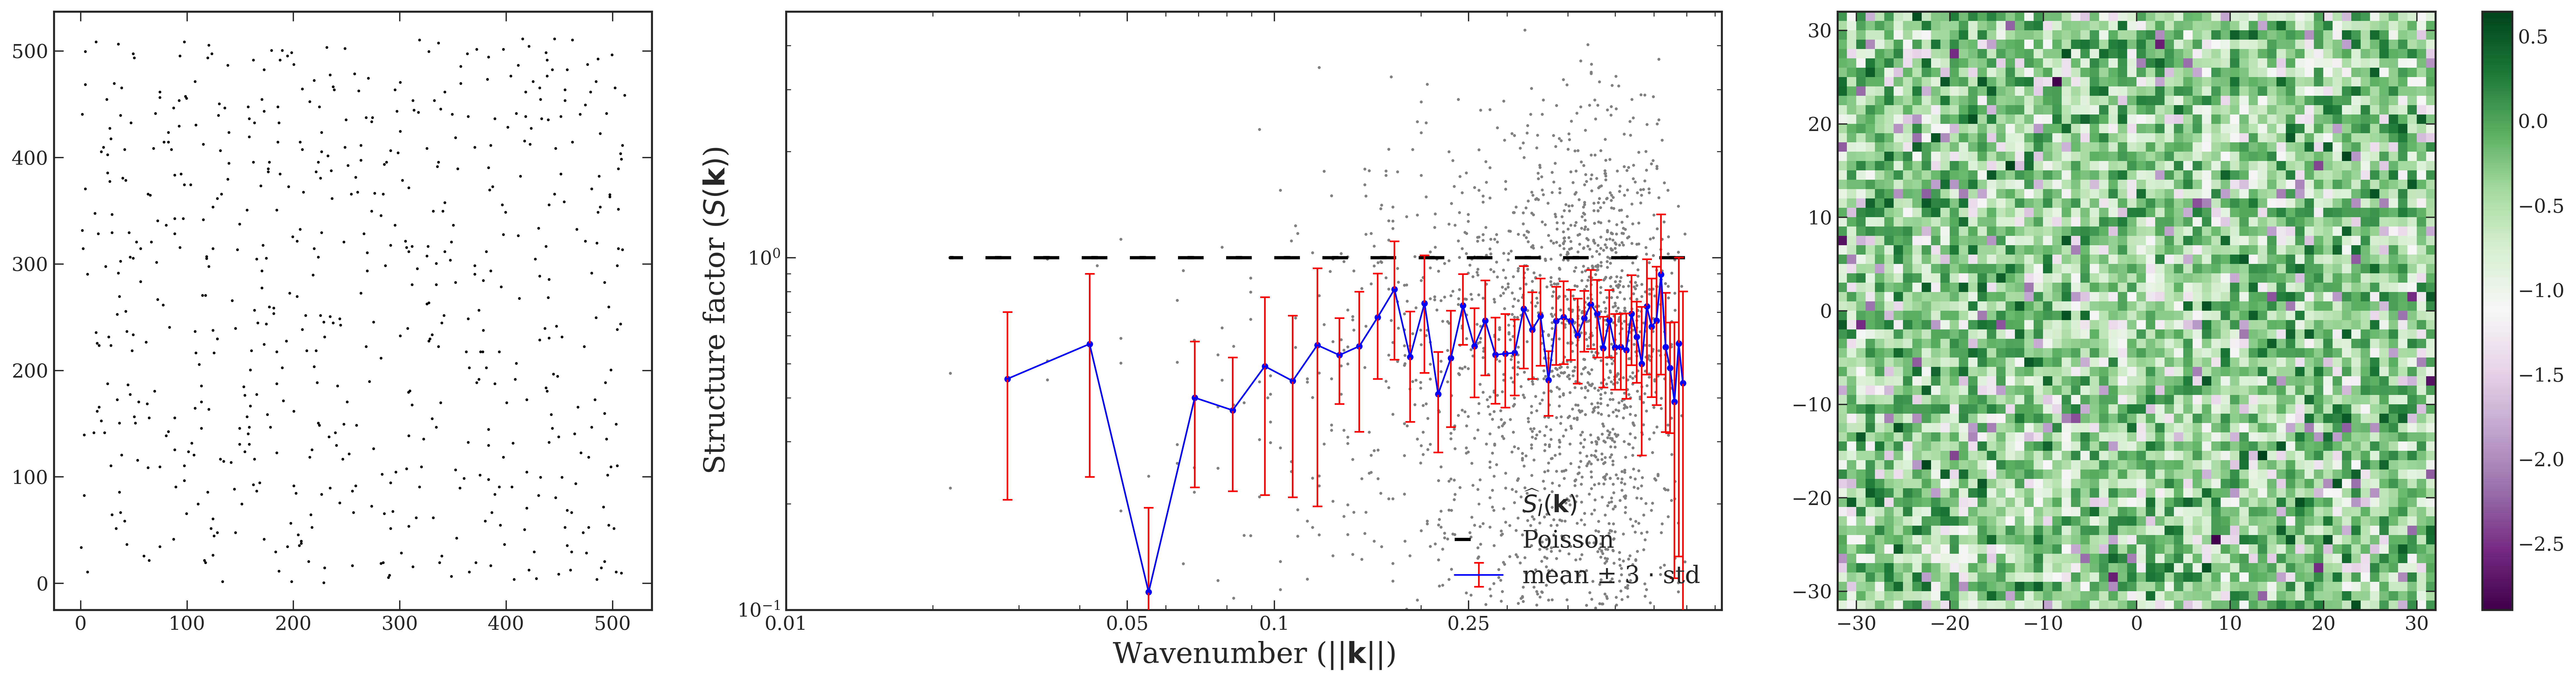

In [18]:
axx = sf.plot_non_isotropic_estimator(
    k,
    sf_estimated,
    plot_type="all",
    error_bar=True,
    bins=50,
    label=r"$\widehat{S}_I (\mathbf{k})$",
)
axx[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);
axx[1].set_ylim([0.1,5])

In [73]:
frame_interval = [0, 1]

LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
rmax = LX/4 - 1
window = BallWindow(center=[LX/2, LX/2], radius=LX/2-1) 
#window = BoxWindow(bounds=[[0, LX], [0, LY]])   

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 50))

R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



In [67]:

window = BoxWindow(bounds=[[0, LX], [0, LY]])   
top_defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

kbins, sf_arr = get_structure_factor(ar, window, frame_interval = frame_interval, kmax = .5, debiased = True, direct = True, nbins = 50,)

Time for structure factor: 13.647084712982178


R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



Time for pair correlation function: 3.3769824504852295


In [31]:


def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    ratio = 4.5 / 7
    w = 7.5
    h = w * ratio
    fig, ax = plt.subplots(ncols=1,figsize=(w, h))
  
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, 0, kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax




In [ ]:
fig, ax = plot_structure_factor(kbins, sf_arr[-1, :, 0], sf_arr[-1, :, 1]);
ax.plot(knorms,sf_estimated, 'g.', markersize=3, alpha=.4)
#ax.set(yticks=np.logspace(-3,1,10), yticklabels=np.round(np.logspace(-3,1,10),3))
ax.set_ylim([0.001,10])
fig.dpi = 720

